In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : False,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_1_1_e_0_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(716456, 828)
(716456, 1)
validation
(107504, 828)
(107504, 1)
test
(80848, 828)
(80848, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/72 [..............................] - ETA: 1:52 - loss: 0.2973 - STD: 1.5739e-04 - MAE: 0.5345

 4/72 [>.............................] - ETA: 2s - loss: 0.1164 - STD: 4.7353e-04 - MAE: 0.2750  

 5/72 [=>............................] - ETA: 2s - loss: 0.0971 - STD: 4.3009e-04 - MAE: 0.2397

 6/72 [=>............................] - ETA: 2s - loss: 0.0860 - STD: 3.8034e-04 - MAE: 0.2228

 7/72 [=>............................] - ETA: 3s - loss: 0.0788 - STD: 3.3561e-04 - MAE: 0.2135

 8/72 [==>...........................] - ETA: 3s - loss: 0.0740 - STD: 2.9773e-04 - MAE: 0.2081

 9/72 [==>...........................] - ETA: 3s - loss: 0.0705 - STD: 2.6611e-04 - MAE: 0.2046

10/72 [===>..........................] - ETA: 3s - loss: 0.0678 - STD: 2.4070e-04 - MAE: 0.2019

11/72 [===>..........................] - ETA: 3s - loss: 0.0653 - STD: 2.2065e-04 - MAE: 0.1993

12/72 [====>.........................] - ETA: 3s - loss: 0.0633 - STD: 2.0457e-04 - MAE: 0.1969

13/72 [====>.........................] - ETA: 3s - loss: 0.0614 - STD: 1.9144e-04 - MAE: 0.1945

14/72 [====>.........................] - ETA: 3s - loss: 0.0594 - STD: 1.8052e-04 - MAE: 0.1915

15/72 [=====>........................] - ETA: 3s - loss: 0.0576 - STD: 1.7134e-04 - MAE: 0.1882

16/72 [=====>........................] - ETA: 3s - loss: 0.0557 - STD: 1.6354e-04 - MAE: 0.1846

17/72 [======>.......................] - ETA: 3s - loss: 0.0539 - STD: 1.5685e-04 - MAE: 0.1804

18/72 [======>.......................] - ETA: 3s - loss: 0.0519 - STD: 1.5104e-04 - MAE: 0.1755

19/72 [======>.......................] - ETA: 3s - loss: 0.0500 - STD: 1.4592e-04 - MAE: 0.1701

20/72 [=======>......................] - ETA: 3s - loss: 0.0482 - STD: 1.4129e-04 - MAE: 0.1646

21/72 [=======>......................] - ETA: 3s - loss: 0.0464 - STD: 1.3702e-04 - MAE: 0.1597

22/72 [========>.....................] - ETA: 3s - loss: 0.0449 - STD: 1.3305e-04 - MAE: 0.1559

23/72 [========>.....................] - ETA: 2s - loss: 0.0435 - STD: 1.2928e-04 - MAE: 0.1530

24/72 [=========>....................] - ETA: 2s - loss: 0.0422 - STD: 1.2565e-04 - MAE: 0.1509

25/72 [=========>....................] - ETA: 2s - loss: 0.0412 - STD: 1.2217e-04 - MAE: 0.1493

26/72 [=========>....................] - ETA: 2s - loss: 0.0403 - STD: 1.1882e-04 - MAE: 0.1481

27/72 [==========>...................] - ETA: 2s - loss: 0.0394 - STD: 1.1559e-04 - MAE: 0.1469

28/72 [==========>...................] - ETA: 2s - loss: 0.0386 - STD: 1.1246e-04 - MAE: 0.1456

29/72 [===========>..................] - ETA: 2s - loss: 0.0378 - STD: 1.0942e-04 - MAE: 0.1442

30/72 [===========>..................] - ETA: 2s - loss: 0.0369 - STD: 1.0648e-04 - MAE: 0.1425

31/72 [===========>..................] - ETA: 2s - loss: 0.0361 - STD: 1.0365e-04 - MAE: 0.1406

32/72 [============>.................] - ETA: 2s - loss: 0.0354 - STD: 1.0093e-04 - MAE: 0.1386

33/72 [============>.................] - ETA: 2s - loss: 0.0347 - STD: 9.8322e-05 - MAE: 0.1364

34/72 [=============>................] - ETA: 2s - loss: 0.0340 - STD: 9.5828e-05 - MAE: 0.1342

35/72 [=============>................] - ETA: 2s - loss: 0.0333 - STD: 9.3453e-05 - MAE: 0.1320

36/72 [==============>...............] - ETA: 2s - loss: 0.0327 - STD: 9.1194e-05 - MAE: 0.1300

37/72 [==============>...............] - ETA: 2s - loss: 0.0322 - STD: 8.9047e-05 - MAE: 0.1281

38/72 [==============>...............] - ETA: 2s - loss: 0.0317 - STD: 8.7006e-05 - MAE: 0.1263

39/72 [===============>..............] - ETA: 2s - loss: 0.0312 - STD: 8.5070e-05 - MAE: 0.1246

40/72 [===============>..............] - ETA: 2s - loss: 0.0307 - STD: 8.3229e-05 - MAE: 0.1230

41/72 [================>.............] - ETA: 1s - loss: 0.0303 - STD: 8.1483e-05 - MAE: 0.1214

42/72 [================>.............] - ETA: 1s - loss: 0.0299 - STD: 7.9827e-05 - MAE: 0.1200

43/72 [================>.............] - ETA: 1s - loss: 0.0294 - STD: 7.8261e-05 - MAE: 0.1185

44/72 [=================>............] - ETA: 1s - loss: 0.0290 - STD: 7.6775e-05 - MAE: 0.1172

45/72 [=================>............] - ETA: 1s - loss: 0.0287 - STD: 7.5368e-05 - MAE: 0.1160

46/72 [==================>...........] - ETA: 1s - loss: 0.0283 - STD: 7.4033e-05 - MAE: 0.1149

47/72 [==================>...........] - ETA: 1s - loss: 0.0279 - STD: 7.2764e-05 - MAE: 0.1139

48/72 [===================>..........] - ETA: 1s - loss: 0.0276 - STD: 7.1556e-05 - MAE: 0.1131

49/72 [===================>..........] - ETA: 1s - loss: 0.0272 - STD: 7.0408e-05 - MAE: 0.1123

50/72 [===================>..........] - ETA: 1s - loss: 0.0269 - STD: 6.9310e-05 - MAE: 0.1116

51/72 [====================>.........] - ETA: 1s - loss: 0.0266 - STD: 6.8260e-05 - MAE: 0.1109

52/72 [====================>.........] - ETA: 1s - loss: 0.0263 - STD: 6.7251e-05 - MAE: 0.1103

53/72 [=====================>........] - ETA: 1s - loss: 0.0260 - STD: 6.6288e-05 - MAE: 0.1096

54/72 [=====================>........] - ETA: 1s - loss: 0.0258 - STD: 6.5361e-05 - MAE: 0.1090

55/72 [=====================>........] - ETA: 1s - loss: 0.0255 - STD: 6.4471e-05 - MAE: 0.1084

56/72 [======================>.......] - ETA: 1s - loss: 0.0253 - STD: 6.3605e-05 - MAE: 0.1077

57/72 [======================>.......] - ETA: 0s - loss: 0.0250 - STD: 6.2774e-05 - MAE: 0.1070

58/72 [=======================>......] - ETA: 0s - loss: 0.0248 - STD: 6.1968e-05 - MAE: 0.1063

59/72 [=======================>......] - ETA: 0s - loss: 0.0245 - STD: 6.1191e-05 - MAE: 0.1056

60/72 [========================>.....] - ETA: 0s - loss: 0.0243 - STD: 6.0442e-05 - MAE: 0.1049

61/72 [========================>.....] - ETA: 0s - loss: 0.0241 - STD: 5.9721e-05 - MAE: 0.1042

62/72 [========================>.....] - ETA: 0s - loss: 0.0239 - STD: 5.9025e-05 - MAE: 0.1036

63/72 [=========================>....] - ETA: 0s - loss: 0.0237 - STD: 5.8351e-05 - MAE: 0.1029

64/72 [=========================>....] - ETA: 0s - loss: 0.0235 - STD: 5.7708e-05 - MAE: 0.1023

65/72 [==========================>...] - ETA: 0s - loss: 0.0233 - STD: 5.7089e-05 - MAE: 0.1017

66/72 [==========================>...] - ETA: 0s - loss: 0.0232 - STD: 5.6493e-05 - MAE: 0.1011

67/72 [==========================>...] - ETA: 0s - loss: 0.0230 - STD: 5.5921e-05 - MAE: 0.1006

68/72 [===========================>..] - ETA: 0s - loss: 0.0228 - STD: 5.5372e-05 - MAE: 0.1000

69/72 [===========================>..] - ETA: 0s - loss: 0.0227 - STD: 5.4846e-05 - MAE: 0.0996

70/72 [============================>.] - ETA: 0s - loss: 0.0225 - STD: 5.4341e-05 - MAE: 0.0991

71/72 [============================>.] - ETA: 0s - loss: 0.0224 - STD: 5.3860e-05 - MAE: 0.0987

72/72 [==============================] - 8s 87ms/step - loss: 0.0222 - STD: 5.3393e-05 - MAE: 0.0983 - val_loss: 0.0136 - val_STD: 1.9100e-05 - val_MAE: 0.0760


Epoch 2/10000


 1/72 [..............................] - ETA: 7s - loss: 0.0112 - STD: 2.0766e-05 - MAE: 0.0702

 2/72 [..............................] - ETA: 5s - loss: 0.0113 - STD: 2.1019e-05 - MAE: 0.0709

 3/72 [>.............................] - ETA: 4s - loss: 0.0112 - STD: 2.1217e-05 - MAE: 0.0704

 4/72 [>.............................] - ETA: 4s - loss: 0.0111 - STD: 2.1283e-05 - MAE: 0.0700

 5/72 [=>............................] - ETA: 4s - loss: 0.0112 - STD: 2.1438e-05 - MAE: 0.0700

 6/72 [=>............................] - ETA: 4s - loss: 0.0112 - STD: 2.1559e-05 - MAE: 0.0697

 7/72 [=>............................] - ETA: 4s - loss: 0.0111 - STD: 2.1702e-05 - MAE: 0.0693

 8/72 [==>...........................] - ETA: 4s - loss: 0.0111 - STD: 2.1810e-05 - MAE: 0.0687

 9/72 [==>...........................] - ETA: 4s - loss: 0.0111 - STD: 2.1972e-05 - MAE: 0.0685

10/72 [===>..........................] - ETA: 4s - loss: 0.0112 - STD: 2.2123e-05 - MAE: 0.0682

11/72 [===>..........................] - ETA: 4s - loss: 0.0112 - STD: 2.2293e-05 - MAE: 0.0679

12/72 [====>.........................] - ETA: 4s - loss: 0.0112 - STD: 2.2482e-05 - MAE: 0.0677

13/72 [====>.........................] - ETA: 4s - loss: 0.0113 - STD: 2.2659e-05 - MAE: 0.0675

14/72 [====>.........................] - ETA: 4s - loss: 0.0112 - STD: 2.2848e-05 - MAE: 0.0673

15/72 [=====>........................] - ETA: 4s - loss: 0.0112 - STD: 2.3053e-05 - MAE: 0.0672

16/72 [=====>........................] - ETA: 3s - loss: 0.0113 - STD: 2.3275e-05 - MAE: 0.0671

17/72 [======>.......................] - ETA: 3s - loss: 0.0113 - STD: 2.3516e-05 - MAE: 0.0671

18/72 [======>.......................] - ETA: 3s - loss: 0.0113 - STD: 2.3763e-05 - MAE: 0.0671

19/72 [======>.......................] - ETA: 3s - loss: 0.0113 - STD: 2.4004e-05 - MAE: 0.0671

20/72 [=======>......................] - ETA: 3s - loss: 0.0112 - STD: 2.4254e-05 - MAE: 0.0671

21/72 [=======>......................] - ETA: 3s - loss: 0.0112 - STD: 2.4515e-05 - MAE: 0.0672

22/72 [========>.....................] - ETA: 3s - loss: 0.0113 - STD: 2.4790e-05 - MAE: 0.0673

24/72 [=========>....................] - ETA: 3s - loss: 0.0113 - STD: 2.5373e-05 - MAE: 0.0675

25/72 [=========>....................] - ETA: 3s - loss: 0.0113 - STD: 2.5668e-05 - MAE: 0.0675

26/72 [=========>....................] - ETA: 3s - loss: 0.0113 - STD: 2.5955e-05 - MAE: 0.0675

27/72 [==========>...................] - ETA: 3s - loss: 0.0113 - STD: 2.6237e-05 - MAE: 0.0675

28/72 [==========>...................] - ETA: 3s - loss: 0.0113 - STD: 2.6541e-05 - MAE: 0.0675

29/72 [===========>..................] - ETA: 2s - loss: 0.0113 - STD: 2.6840e-05 - MAE: 0.0674

30/72 [===========>..................] - ETA: 2s - loss: 0.0112 - STD: 2.7148e-05 - MAE: 0.0673

31/72 [===========>..................] - ETA: 2s - loss: 0.0112 - STD: 2.7458e-05 - MAE: 0.0673

32/72 [============>.................] - ETA: 2s - loss: 0.0112 - STD: 2.7791e-05 - MAE: 0.0672

33/72 [============>.................] - ETA: 2s - loss: 0.0112 - STD: 2.8123e-05 - MAE: 0.0672

34/72 [=============>................] - ETA: 2s - loss: 0.0112 - STD: 2.8457e-05 - MAE: 0.0671

35/72 [=============>................] - ETA: 2s - loss: 0.0112 - STD: 2.8818e-05 - MAE: 0.0671

36/72 [==============>...............] - ETA: 2s - loss: 0.0112 - STD: 2.9191e-05 - MAE: 0.0671

37/72 [==============>...............] - ETA: 2s - loss: 0.0112 - STD: 2.9572e-05 - MAE: 0.0670

38/72 [==============>...............] - ETA: 2s - loss: 0.0112 - STD: 2.9982e-05 - MAE: 0.0671

39/72 [===============>..............] - ETA: 2s - loss: 0.0112 - STD: 3.0394e-05 - MAE: 0.0671

40/72 [===============>..............] - ETA: 2s - loss: 0.0112 - STD: 3.0829e-05 - MAE: 0.0671

41/72 [================>.............] - ETA: 2s - loss: 0.0113 - STD: 3.1286e-05 - MAE: 0.0671

42/72 [================>.............] - ETA: 2s - loss: 0.0113 - STD: 3.1747e-05 - MAE: 0.0671

43/72 [================>.............] - ETA: 2s - loss: 0.0113 - STD: 3.2217e-05 - MAE: 0.0671

44/72 [=================>............] - ETA: 1s - loss: 0.0113 - STD: 3.2719e-05 - MAE: 0.0671

45/72 [=================>............] - ETA: 1s - loss: 0.0113 - STD: 3.3240e-05 - MAE: 0.0671

46/72 [==================>...........] - ETA: 1s - loss: 0.0113 - STD: 3.3764e-05 - MAE: 0.0671

47/72 [==================>...........] - ETA: 1s - loss: 0.0113 - STD: 3.4320e-05 - MAE: 0.0671

48/72 [===================>..........] - ETA: 1s - loss: 0.0113 - STD: 3.4896e-05 - MAE: 0.0671

49/72 [===================>..........] - ETA: 1s - loss: 0.0113 - STD: 3.5493e-05 - MAE: 0.0672

50/72 [===================>..........] - ETA: 1s - loss: 0.0113 - STD: 3.6085e-05 - MAE: 0.0671

51/72 [====================>.........] - ETA: 1s - loss: 0.0113 - STD: 3.6709e-05 - MAE: 0.0671

52/72 [====================>.........] - ETA: 1s - loss: 0.0113 - STD: 3.7370e-05 - MAE: 0.0671

53/72 [=====================>........] - ETA: 1s - loss: 0.0113 - STD: 3.8070e-05 - MAE: 0.0671

54/72 [=====================>........] - ETA: 1s - loss: 0.0113 - STD: 3.8781e-05 - MAE: 0.0671

55/72 [=====================>........] - ETA: 1s - loss: 0.0113 - STD: 3.9539e-05 - MAE: 0.0671

56/72 [======================>.......] - ETA: 1s - loss: 0.0113 - STD: 4.0309e-05 - MAE: 0.0671

57/72 [======================>.......] - ETA: 1s - loss: 0.0113 - STD: 4.1127e-05 - MAE: 0.0671

58/72 [=======================>......] - ETA: 0s - loss: 0.0113 - STD: 4.1952e-05 - MAE: 0.0671

59/72 [=======================>......] - ETA: 0s - loss: 0.0113 - STD: 4.2851e-05 - MAE: 0.0671

60/72 [========================>.....] - ETA: 0s - loss: 0.0113 - STD: 4.3772e-05 - MAE: 0.0671

61/72 [========================>.....] - ETA: 0s - loss: 0.0113 - STD: 4.4753e-05 - MAE: 0.0671

62/72 [========================>.....] - ETA: 0s - loss: 0.0113 - STD: 4.5753e-05 - MAE: 0.0671

63/72 [=========================>....] - ETA: 0s - loss: 0.0113 - STD: 4.6800e-05 - MAE: 0.0671

64/72 [=========================>....] - ETA: 0s - loss: 0.0113 - STD: 4.7844e-05 - MAE: 0.0671

65/72 [==========================>...] - ETA: 0s - loss: 0.0113 - STD: 4.8911e-05 - MAE: 0.0671

66/72 [==========================>...] - ETA: 0s - loss: 0.0113 - STD: 5.0016e-05 - MAE: 0.0671

67/72 [==========================>...] - ETA: 0s - loss: 0.0113 - STD: 5.1144e-05 - MAE: 0.0671

68/72 [===========================>..] - ETA: 0s - loss: 0.0113 - STD: 5.2339e-05 - MAE: 0.0671

69/72 [===========================>..] - ETA: 0s - loss: 0.0113 - STD: 5.3531e-05 - MAE: 0.0671

70/72 [============================>.] - ETA: 0s - loss: 0.0113 - STD: 5.4747e-05 - MAE: 0.0671

71/72 [============================>.] - ETA: 0s - loss: 0.0113 - STD: 5.6011e-05 - MAE: 0.0670

72/72 [==============================] - ETA: 0s - loss: 0.0113 - STD: 5.7293e-05 - MAE: 0.0670

72/72 [==============================] - 5s 73ms/step - loss: 0.0113 - STD: 5.7293e-05 - MAE: 0.0670 - val_loss: 0.0136 - val_STD: 1.4324e-04 - val_MAE: 0.0721


Epoch 3/10000


 1/72 [..............................] - ETA: 7s - loss: 0.0112 - STD: 1.5434e-04 - MAE: 0.0664

 2/72 [..............................] - ETA: 5s - loss: 0.0112 - STD: 1.5692e-04 - MAE: 0.0665

 3/72 [>.............................] - ETA: 4s - loss: 0.0113 - STD: 1.5969e-04 - MAE: 0.0669

 4/72 [>.............................] - ETA: 4s - loss: 0.0112 - STD: 1.6156e-04 - MAE: 0.0666

 5/72 [=>............................] - ETA: 4s - loss: 0.0113 - STD: 1.6470e-04 - MAE: 0.0669

 6/72 [=>............................] - ETA: 4s - loss: 0.0113 - STD: 1.6728e-04 - MAE: 0.0669

 7/72 [=>............................] - ETA: 4s - loss: 0.0112 - STD: 1.7007e-04 - MAE: 0.0668

 8/72 [==>...........................] - ETA: 4s - loss: 0.0113 - STD: 1.7309e-04 - MAE: 0.0669

 9/72 [==>...........................] - ETA: 4s - loss: 0.0113 - STD: 1.7624e-04 - MAE: 0.0670

10/72 [===>..........................] - ETA: 4s - loss: 0.0113 - STD: 1.7946e-04 - MAE: 0.0670

11/72 [===>..........................] - ETA: 4s - loss: 0.0112 - STD: 1.8265e-04 - MAE: 0.0669

12/72 [====>.........................] - ETA: 4s - loss: 0.0112 - STD: 1.8597e-04 - MAE: 0.0668

13/72 [====>.........................] - ETA: 4s - loss: 0.0112 - STD: 1.8968e-04 - MAE: 0.0668

14/72 [====>.........................] - ETA: 3s - loss: 0.0112 - STD: 1.9319e-04 - MAE: 0.0668

15/72 [=====>........................] - ETA: 3s - loss: 0.0112 - STD: 1.9674e-04 - MAE: 0.0667

16/72 [=====>........................] - ETA: 3s - loss: 0.0113 - STD: 2.0065e-04 - MAE: 0.0668

17/72 [======>.......................] - ETA: 3s - loss: 0.0113 - STD: 2.0486e-04 - MAE: 0.0669

18/72 [======>.......................] - ETA: 3s - loss: 0.0113 - STD: 2.0893e-04 - MAE: 0.0668

19/72 [======>.......................] - ETA: 3s - loss: 0.0113 - STD: 2.1314e-04 - MAE: 0.0668

20/72 [=======>......................] - ETA: 3s - loss: 0.0113 - STD: 2.1778e-04 - MAE: 0.0668

21/72 [=======>......................] - ETA: 3s - loss: 0.0113 - STD: 2.2279e-04 - MAE: 0.0669

22/72 [========>.....................] - ETA: 3s - loss: 0.0113 - STD: 2.2774e-04 - MAE: 0.0669

23/72 [========>.....................] - ETA: 3s - loss: 0.0113 - STD: 2.3286e-04 - MAE: 0.0669

24/72 [=========>....................] - ETA: 3s - loss: 0.0113 - STD: 2.3815e-04 - MAE: 0.0669

25/72 [=========>....................] - ETA: 3s - loss: 0.0113 - STD: 2.4377e-04 - MAE: 0.0669

26/72 [=========>....................] - ETA: 3s - loss: 0.0113 - STD: 2.4967e-04 - MAE: 0.0670

27/72 [==========>...................] - ETA: 3s - loss: 0.0113 - STD: 2.5566e-04 - MAE: 0.0670

28/72 [==========>...................] - ETA: 2s - loss: 0.0113 - STD: 2.6186e-04 - MAE: 0.0670

29/72 [===========>..................] - ETA: 2s - loss: 0.0113 - STD: 2.6823e-04 - MAE: 0.0670

30/72 [===========>..................] - ETA: 2s - loss: 0.0113 - STD: 2.7463e-04 - MAE: 0.0669

31/72 [===========>..................] - ETA: 2s - loss: 0.0113 - STD: 2.8138e-04 - MAE: 0.0669

32/72 [============>.................] - ETA: 2s - loss: 0.0113 - STD: 2.8842e-04 - MAE: 0.0668

33/72 [============>.................] - ETA: 2s - loss: 0.0112 - STD: 2.9572e-04 - MAE: 0.0668

34/72 [=============>................] - ETA: 2s - loss: 0.0112 - STD: 3.0331e-04 - MAE: 0.0667

35/72 [=============>................] - ETA: 2s - loss: 0.0112 - STD: 3.1124e-04 - MAE: 0.0667

36/72 [==============>...............] - ETA: 2s - loss: 0.0112 - STD: 3.1946e-04 - MAE: 0.0666

37/72 [==============>...............] - ETA: 2s - loss: 0.0112 - STD: 3.2820e-04 - MAE: 0.0666

38/72 [==============>...............] - ETA: 2s - loss: 0.0112 - STD: 3.3727e-04 - MAE: 0.0666

39/72 [===============>..............] - ETA: 2s - loss: 0.0112 - STD: 3.4660e-04 - MAE: 0.0666

40/72 [===============>..............] - ETA: 2s - loss: 0.0112 - STD: 3.5634e-04 - MAE: 0.0665

41/72 [================>.............] - ETA: 2s - loss: 0.0112 - STD: 3.6652e-04 - MAE: 0.0666

42/72 [================>.............] - ETA: 2s - loss: 0.0112 - STD: 3.7709e-04 - MAE: 0.0666

43/72 [================>.............] - ETA: 1s - loss: 0.0112 - STD: 3.8844e-04 - MAE: 0.0666

44/72 [=================>............] - ETA: 1s - loss: 0.0112 - STD: 4.0010e-04 - MAE: 0.0666

45/72 [=================>............] - ETA: 1s - loss: 0.0112 - STD: 4.1234e-04 - MAE: 0.0666

46/72 [==================>...........] - ETA: 1s - loss: 0.0112 - STD: 4.2491e-04 - MAE: 0.0666

47/72 [==================>...........] - ETA: 1s - loss: 0.0112 - STD: 4.3801e-04 - MAE: 0.0666

48/72 [===================>..........] - ETA: 1s - loss: 0.0112 - STD: 4.5198e-04 - MAE: 0.0666

49/72 [===================>..........] - ETA: 1s - loss: 0.0112 - STD: 4.6669e-04 - MAE: 0.0667

50/72 [===================>..........] - ETA: 1s - loss: 0.0112 - STD: 4.8193e-04 - MAE: 0.0667

51/72 [====================>.........] - ETA: 1s - loss: 0.0112 - STD: 4.9800e-04 - MAE: 0.0667

52/72 [====================>.........] - ETA: 1s - loss: 0.0112 - STD: 5.1459e-04 - MAE: 0.0667

53/72 [=====================>........] - ETA: 1s - loss: 0.0112 - STD: 5.3215e-04 - MAE: 0.0666

54/72 [=====================>........] - ETA: 1s - loss: 0.0112 - STD: 5.5034e-04 - MAE: 0.0666

55/72 [=====================>........] - ETA: 1s - loss: 0.0112 - STD: 5.6968e-04 - MAE: 0.0666

57/72 [======================>.......] - ETA: 1s - loss: 0.0112 - STD: 6.1096e-04 - MAE: 0.0666

58/72 [=======================>......] - ETA: 0s - loss: 0.0112 - STD: 6.3345e-04 - MAE: 0.0666

59/72 [=======================>......] - ETA: 0s - loss: 0.0112 - STD: 6.5727e-04 - MAE: 0.0666

60/72 [========================>.....] - ETA: 0s - loss: 0.0112 - STD: 6.8201e-04 - MAE: 0.0665

61/72 [========================>.....] - ETA: 0s - loss: 0.0112 - STD: 7.0865e-04 - MAE: 0.0665

62/72 [========================>.....] - ETA: 0s - loss: 0.0112 - STD: 7.3681e-04 - MAE: 0.0665

63/72 [=========================>....] - ETA: 0s - loss: 0.0112 - STD: 7.6608e-04 - MAE: 0.0665

64/72 [=========================>....] - ETA: 0s - loss: 0.0112 - STD: 7.9688e-04 - MAE: 0.0665

65/72 [==========================>...] - ETA: 0s - loss: 0.0112 - STD: 8.2973e-04 - MAE: 0.0665

66/72 [==========================>...] - ETA: 0s - loss: 0.0112 - STD: 8.6440e-04 - MAE: 0.0665

67/72 [==========================>...] - ETA: 0s - loss: 0.0112 - STD: 9.0082e-04 - MAE: 0.0665

68/72 [===========================>..] - ETA: 0s - loss: 0.0111 - STD: 9.3962e-04 - MAE: 0.0665

69/72 [===========================>..] - ETA: 0s - loss: 0.0112 - STD: 9.8052e-04 - MAE: 0.0665

70/72 [============================>.] - ETA: 0s - loss: 0.0111 - STD: 0.0010 - MAE: 0.0664    

71/72 [============================>.] - ETA: 0s - loss: 0.0111 - STD: 0.0011 - MAE: 0.0664

72/72 [==============================] - ETA: 0s - loss: 0.0111 - STD: 0.0011 - MAE: 0.0664

72/72 [==============================] - 5s 72ms/step - loss: 0.0111 - STD: 0.0011 - MAE: 0.0664 - val_loss: 0.0128 - val_STD: 0.0043 - val_MAE: 0.0699


Epoch 4/10000


 1/72 [..............................] - ETA: 7s - loss: 0.0106 - STD: 0.0048 - MAE: 0.0649

 2/72 [..............................] - ETA: 5s - loss: 0.0106 - STD: 0.0049 - MAE: 0.0647

 3/72 [>.............................] - ETA: 4s - loss: 0.0107 - STD: 0.0051 - MAE: 0.0648

 4/72 [>.............................] - ETA: 4s - loss: 0.0108 - STD: 0.0052 - MAE: 0.0648

 5/72 [=>............................] - ETA: 4s - loss: 0.0106 - STD: 0.0054 - MAE: 0.0645

 6/72 [=>............................] - ETA: 4s - loss: 0.0106 - STD: 0.0056 - MAE: 0.0645

 7/72 [=>............................] - ETA: 4s - loss: 0.0106 - STD: 0.0058 - MAE: 0.0644

 8/72 [==>...........................] - ETA: 4s - loss: 0.0105 - STD: 0.0060 - MAE: 0.0642

 9/72 [==>...........................] - ETA: 4s - loss: 0.0105 - STD: 0.0062 - MAE: 0.0643

10/72 [===>..........................] - ETA: 4s - loss: 0.0105 - STD: 0.0064 - MAE: 0.0642

11/72 [===>..........................] - ETA: 4s - loss: 0.0105 - STD: 0.0066 - MAE: 0.0642

12/72 [====>.........................] - ETA: 4s - loss: 0.0105 - STD: 0.0068 - MAE: 0.0641

13/72 [====>.........................] - ETA: 4s - loss: 0.0105 - STD: 0.0071 - MAE: 0.0641

14/72 [====>.........................] - ETA: 3s - loss: 0.0104 - STD: 0.0073 - MAE: 0.0639

16/72 [=====>........................] - ETA: 3s - loss: 0.0104 - STD: 0.0078 - MAE: 0.0638

17/72 [======>.......................] - ETA: 3s - loss: 0.0103 - STD: 0.0081 - MAE: 0.0637

18/72 [======>.......................] - ETA: 3s - loss: 0.0102 - STD: 0.0084 - MAE: 0.0635

19/72 [======>.......................] - ETA: 3s - loss: 0.0102 - STD: 0.0087 - MAE: 0.0634

20/72 [=======>......................] - ETA: 3s - loss: 0.0102 - STD: 0.0090 - MAE: 0.0632

21/72 [=======>......................] - ETA: 3s - loss: 0.0101 - STD: 0.0093 - MAE: 0.0630

22/72 [========>.....................] - ETA: 3s - loss: 0.0100 - STD: 0.0096 - MAE: 0.0628

23/72 [========>.....................] - ETA: 3s - loss: 0.0100 - STD: 0.0099 - MAE: 0.0626

24/72 [=========>....................] - ETA: 3s - loss: 0.0099 - STD: 0.0103 - MAE: 0.0624

25/72 [=========>....................] - ETA: 3s - loss: 0.0099 - STD: 0.0107 - MAE: 0.0622

26/72 [=========>....................] - ETA: 3s - loss: 0.0098 - STD: 0.0111 - MAE: 0.0621

27/72 [==========>...................] - ETA: 3s - loss: 0.0098 - STD: 0.0115 - MAE: 0.0618

28/72 [==========>...................] - ETA: 2s - loss: 0.0097 - STD: 0.0119 - MAE: 0.0616

29/72 [===========>..................] - ETA: 2s - loss: 0.0097 - STD: 0.0123 - MAE: 0.0615

30/72 [===========>..................] - ETA: 2s - loss: 0.0096 - STD: 0.0127 - MAE: 0.0613

31/72 [===========>..................] - ETA: 2s - loss: 0.0096 - STD: 0.0132 - MAE: 0.0611

32/72 [============>.................] - ETA: 2s - loss: 0.0095 - STD: 0.0136 - MAE: 0.0609

33/72 [============>.................] - ETA: 2s - loss: 0.0094 - STD: 0.0141 - MAE: 0.0607

34/72 [=============>................] - ETA: 2s - loss: 0.0094 - STD: 0.0146 - MAE: 0.0605

35/72 [=============>................] - ETA: 2s - loss: 0.0093 - STD: 0.0150 - MAE: 0.0603

36/72 [==============>...............] - ETA: 2s - loss: 0.0093 - STD: 0.0155 - MAE: 0.0600

37/72 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 0.0161 - MAE: 0.0598

38/72 [==============>...............] - ETA: 2s - loss: 0.0091 - STD: 0.0166 - MAE: 0.0596

39/72 [===============>..............] - ETA: 2s - loss: 0.0091 - STD: 0.0172 - MAE: 0.0594

40/72 [===============>..............] - ETA: 2s - loss: 0.0090 - STD: 0.0178 - MAE: 0.0592

41/72 [================>.............] - ETA: 2s - loss: 0.0090 - STD: 0.0184 - MAE: 0.0589

42/72 [================>.............] - ETA: 2s - loss: 0.0089 - STD: 0.0189 - MAE: 0.0587

43/72 [================>.............] - ETA: 1s - loss: 0.0088 - STD: 0.0195 - MAE: 0.0585

44/72 [=================>............] - ETA: 1s - loss: 0.0088 - STD: 0.0201 - MAE: 0.0582

45/72 [=================>............] - ETA: 1s - loss: 0.0087 - STD: 0.0207 - MAE: 0.0580

46/72 [==================>...........] - ETA: 1s - loss: 0.0086 - STD: 0.0214 - MAE: 0.0578

47/72 [==================>...........] - ETA: 1s - loss: 0.0086 - STD: 0.0220 - MAE: 0.0575

48/72 [===================>..........] - ETA: 1s - loss: 0.0085 - STD: 0.0226 - MAE: 0.0573

49/72 [===================>..........] - ETA: 1s - loss: 0.0084 - STD: 0.0233 - MAE: 0.0571

50/72 [===================>..........] - ETA: 1s - loss: 0.0084 - STD: 0.0239 - MAE: 0.0568

51/72 [====================>.........] - ETA: 1s - loss: 0.0083 - STD: 0.0246 - MAE: 0.0566

52/72 [====================>.........] - ETA: 1s - loss: 0.0082 - STD: 0.0252 - MAE: 0.0563

53/72 [=====================>........] - ETA: 1s - loss: 0.0082 - STD: 0.0259 - MAE: 0.0561

54/72 [=====================>........] - ETA: 1s - loss: 0.0081 - STD: 0.0266 - MAE: 0.0559

55/72 [=====================>........] - ETA: 1s - loss: 0.0080 - STD: 0.0272 - MAE: 0.0557

56/72 [======================>.......] - ETA: 1s - loss: 0.0080 - STD: 0.0279 - MAE: 0.0554

57/72 [======================>.......] - ETA: 1s - loss: 0.0079 - STD: 0.0285 - MAE: 0.0552

58/72 [=======================>......] - ETA: 0s - loss: 0.0079 - STD: 0.0291 - MAE: 0.0550

59/72 [=======================>......] - ETA: 0s - loss: 0.0078 - STD: 0.0298 - MAE: 0.0548

60/72 [========================>.....] - ETA: 0s - loss: 0.0077 - STD: 0.0304 - MAE: 0.0546

61/72 [========================>.....] - ETA: 0s - loss: 0.0077 - STD: 0.0310 - MAE: 0.0544

62/72 [========================>.....] - ETA: 0s - loss: 0.0076 - STD: 0.0317 - MAE: 0.0542

63/72 [=========================>....] - ETA: 0s - loss: 0.0076 - STD: 0.0323 - MAE: 0.0540

64/72 [=========================>....] - ETA: 0s - loss: 0.0075 - STD: 0.0329 - MAE: 0.0538

65/72 [==========================>...] - ETA: 0s - loss: 0.0075 - STD: 0.0335 - MAE: 0.0536

66/72 [==========================>...] - ETA: 0s - loss: 0.0074 - STD: 0.0341 - MAE: 0.0534

67/72 [==========================>...] - ETA: 0s - loss: 0.0074 - STD: 0.0346 - MAE: 0.0532

68/72 [===========================>..] - ETA: 0s - loss: 0.0073 - STD: 0.0352 - MAE: 0.0530

69/72 [===========================>..] - ETA: 0s - loss: 0.0073 - STD: 0.0358 - MAE: 0.0528

70/72 [============================>.] - ETA: 0s - loss: 0.0072 - STD: 0.0363 - MAE: 0.0526

71/72 [============================>.] - ETA: 0s - loss: 0.0072 - STD: 0.0369 - MAE: 0.0524

72/72 [==============================] - ETA: 0s - loss: 0.0071 - STD: 0.0374 - MAE: 0.0523

72/72 [==============================] - 5s 73ms/step - loss: 0.0071 - STD: 0.0374 - MAE: 0.0523 - val_loss: 0.0042 - val_STD: 0.0740 - val_MAE: 0.0418


Epoch 5/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0393

 2/72 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0396

 3/72 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0395

 4/72 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0396

 5/72 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0397

 6/72 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0397

 7/72 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0395

 8/72 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0396

 9/72 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0394

10/72 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0394

11/72 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0394

12/72 [====>.........................] - ETA: 4s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0394

13/72 [====>.........................] - ETA: 4s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0393

14/72 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0392

15/72 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0391

17/72 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0392

18/72 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0391

19/72 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0391

20/72 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0390

21/72 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0390

22/72 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0390

23/72 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0390

24/72 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0804 - MAE: 0.0390

25/72 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0806 - MAE: 0.0390

26/72 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0808 - MAE: 0.0390

27/72 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0809 - MAE: 0.0389

28/72 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0811 - MAE: 0.0389

29/72 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0812 - MAE: 0.0389

30/72 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0813 - MAE: 0.0388

31/72 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0815 - MAE: 0.0388

32/72 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0816 - MAE: 0.0388

33/72 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0816 - MAE: 0.0388

34/72 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0817 - MAE: 0.0387

35/72 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0818 - MAE: 0.0387

36/72 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0818 - MAE: 0.0387

37/72 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0820 - MAE: 0.0387

38/72 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0821 - MAE: 0.0387

39/72 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0821 - MAE: 0.0386

40/72 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0822 - MAE: 0.0386

41/72 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0822 - MAE: 0.0385

42/72 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0823 - MAE: 0.0385

43/72 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0825 - MAE: 0.0385

44/72 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0825 - MAE: 0.0385

45/72 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0826 - MAE: 0.0384

46/72 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0827 - MAE: 0.0384

47/72 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0828 - MAE: 0.0384

48/72 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0828 - MAE: 0.0383

49/72 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0829 - MAE: 0.0383

50/72 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0831 - MAE: 0.0383

51/72 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0831 - MAE: 0.0383

52/72 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0832 - MAE: 0.0383

53/72 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0833 - MAE: 0.0382

54/72 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0833 - MAE: 0.0382

55/72 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0833 - MAE: 0.0382

56/72 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0834 - MAE: 0.0382

57/72 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0834 - MAE: 0.0381

58/72 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0836 - MAE: 0.0381

59/72 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0836 - MAE: 0.0381

60/72 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0836 - MAE: 0.0381

61/72 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0836 - MAE: 0.0380

62/72 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0837 - MAE: 0.0380

63/72 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0838 - MAE: 0.0380

64/72 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0838 - MAE: 0.0380

65/72 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0839 - MAE: 0.0380

66/72 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0839 - MAE: 0.0380

67/72 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0840 - MAE: 0.0380

68/72 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0841 - MAE: 0.0379

69/72 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0842 - MAE: 0.0379

70/72 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0842 - MAE: 0.0379

71/72 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0842 - MAE: 0.0379

72/72 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0843 - MAE: 0.0379

72/72 [==============================] - 5s 72ms/step - loss: 0.0034 - STD: 0.0843 - MAE: 0.0379 - val_loss: 0.0033 - val_STD: 0.0842 - val_MAE: 0.0370


Epoch 6/10000


 1/72 [..............................] - ETA: 7s - loss: 0.0032 - STD: 0.0870 - MAE: 0.0365

 2/72 [..............................] - ETA: 5s - loss: 0.0033 - STD: 0.0854 - MAE: 0.0367

 3/72 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0869 - MAE: 0.0365

 4/72 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0875 - MAE: 0.0367

 5/72 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0868 - MAE: 0.0365

 6/72 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0864 - MAE: 0.0366

 7/72 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0866 - MAE: 0.0365

 8/72 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0870 - MAE: 0.0366

 9/72 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0868 - MAE: 0.0366

10/72 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0865 - MAE: 0.0365

11/72 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0866 - MAE: 0.0365

12/72 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0869 - MAE: 0.0365

13/72 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0868 - MAE: 0.0365

14/72 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0869 - MAE: 0.0365

15/72 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0873 - MAE: 0.0365

16/72 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0875 - MAE: 0.0365

17/72 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0876 - MAE: 0.0364

18/72 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0875 - MAE: 0.0364

19/72 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0875 - MAE: 0.0364

20/72 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0875 - MAE: 0.0364

21/72 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0875 - MAE: 0.0363

22/72 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0874 - MAE: 0.0363

23/72 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0876 - MAE: 0.0363

24/72 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0877 - MAE: 0.0364

25/72 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0877 - MAE: 0.0364

26/72 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0877 - MAE: 0.0364

27/72 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0878 - MAE: 0.0364

28/72 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0878 - MAE: 0.0364

29/72 [===========>..................] - ETA: 3s - loss: 0.0032 - STD: 0.0879 - MAE: 0.0363

30/72 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0878 - MAE: 0.0363

31/72 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0879 - MAE: 0.0363

32/72 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0879 - MAE: 0.0363

33/72 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0879 - MAE: 0.0362

34/72 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0880 - MAE: 0.0362

35/72 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0881 - MAE: 0.0362

36/72 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0881 - MAE: 0.0362

37/72 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0881 - MAE: 0.0362

38/72 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0881 - MAE: 0.0362

39/72 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0881 - MAE: 0.0362

40/72 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0881 - MAE: 0.0362

41/72 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0882 - MAE: 0.0362

42/72 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0882 - MAE: 0.0362

43/72 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0881 - MAE: 0.0361

44/72 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0882 - MAE: 0.0362

45/72 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0882 - MAE: 0.0362

46/72 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0882 - MAE: 0.0362

48/72 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0883 - MAE: 0.0362

49/72 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0882 - MAE: 0.0362

50/72 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0882 - MAE: 0.0362

51/72 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0882 - MAE: 0.0362

52/72 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0882 - MAE: 0.0362

53/72 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0881 - MAE: 0.0362

54/72 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0883 - MAE: 0.0362

55/72 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0884 - MAE: 0.0362

56/72 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0883 - MAE: 0.0362

57/72 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0883 - MAE: 0.0362

58/72 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0883 - MAE: 0.0362

59/72 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0882 - MAE: 0.0362

60/72 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0882 - MAE: 0.0362

61/72 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0883 - MAE: 0.0362

62/72 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0884 - MAE: 0.0362

63/72 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0884 - MAE: 0.0361

64/72 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0884 - MAE: 0.0361

65/72 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0885 - MAE: 0.0361

66/72 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0885 - MAE: 0.0361

67/72 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0884 - MAE: 0.0361

68/72 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0885 - MAE: 0.0361

69/72 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0885 - MAE: 0.0361

70/72 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0885 - MAE: 0.0361

71/72 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0885 - MAE: 0.0360

72/72 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0885 - MAE: 0.0360

72/72 [==============================] - 5s 73ms/step - loss: 0.0031 - STD: 0.0885 - MAE: 0.0360 - val_loss: 0.0030 - val_STD: 0.0861 - val_MAE: 0.0357


Epoch 7/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0884 - MAE: 0.0350

 2/72 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0865 - MAE: 0.0353

 3/72 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0875 - MAE: 0.0351

 4/72 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0876 - MAE: 0.0351

 5/72 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0884 - MAE: 0.0350

 6/72 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0883 - MAE: 0.0351

 7/72 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0891 - MAE: 0.0354

 8/72 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0886 - MAE: 0.0353

 9/72 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0884 - MAE: 0.0354

10/72 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0886 - MAE: 0.0354

11/72 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0886 - MAE: 0.0353

12/72 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0885 - MAE: 0.0353

13/72 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0885 - MAE: 0.0353

14/72 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0886 - MAE: 0.0352

15/72 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0888 - MAE: 0.0352

16/72 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0889 - MAE: 0.0352

17/72 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0890 - MAE: 0.0352

18/72 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0889 - MAE: 0.0352

19/72 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0891 - MAE: 0.0352

20/72 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0892 - MAE: 0.0352

21/72 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0891 - MAE: 0.0352

22/72 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0892 - MAE: 0.0351

23/72 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0893 - MAE: 0.0351

24/72 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0892 - MAE: 0.0351

25/72 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0892 - MAE: 0.0351

26/72 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0894 - MAE: 0.0351

27/72 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0892 - MAE: 0.0351

28/72 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0891 - MAE: 0.0351

29/72 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0893 - MAE: 0.0352

30/72 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0892 - MAE: 0.0352

31/72 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0893 - MAE: 0.0352

32/72 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0896 - MAE: 0.0352

33/72 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0896 - MAE: 0.0351

34/72 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0896 - MAE: 0.0351

35/72 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0897 - MAE: 0.0351

36/72 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0897 - MAE: 0.0351

37/72 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0895 - MAE: 0.0351

38/72 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0896 - MAE: 0.0351

39/72 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0897 - MAE: 0.0351

40/72 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0896 - MAE: 0.0351

41/72 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0897 - MAE: 0.0351

43/72 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0897 - MAE: 0.0351

44/72 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0897 - MAE: 0.0351

45/72 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0898 - MAE: 0.0351

46/72 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0898 - MAE: 0.0351

47/72 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0898 - MAE: 0.0351

48/72 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0899 - MAE: 0.0351

49/72 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0899 - MAE: 0.0350

50/72 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0899 - MAE: 0.0350

51/72 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0899 - MAE: 0.0350

52/72 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0900 - MAE: 0.0350

53/72 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0899 - MAE: 0.0350

54/72 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0900 - MAE: 0.0350

55/72 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0901 - MAE: 0.0350

56/72 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0900 - MAE: 0.0350

57/72 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0901 - MAE: 0.0350

58/72 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0901 - MAE: 0.0350

59/72 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0901 - MAE: 0.0350

60/72 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0901 - MAE: 0.0350

61/72 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0901 - MAE: 0.0350

62/72 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0901 - MAE: 0.0350

63/72 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0901 - MAE: 0.0350

64/72 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0901 - MAE: 0.0349

65/72 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0901 - MAE: 0.0349

66/72 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0902 - MAE: 0.0349

67/72 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0902 - MAE: 0.0349

68/72 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0902 - MAE: 0.0349

69/72 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0902 - MAE: 0.0349

70/72 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0901 - MAE: 0.0348

71/72 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0901 - MAE: 0.0348

72/72 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0901 - MAE: 0.0348

72/72 [==============================] - 5s 72ms/step - loss: 0.0029 - STD: 0.0901 - MAE: 0.0348 - val_loss: 0.0028 - val_STD: 0.0834 - val_MAE: 0.0338


Epoch 8/10000


 1/72 [..............................] - ETA: 7s - loss: 0.0028 - STD: 0.0884 - MAE: 0.0346

 2/72 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0889 - MAE: 0.0344

 3/72 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0894 - MAE: 0.0343

 4/72 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0884 - MAE: 0.0346

 5/72 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0893 - MAE: 0.0347

 6/72 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0899 - MAE: 0.0346

 7/72 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0894 - MAE: 0.0348

 8/72 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0903 - MAE: 0.0348

 9/72 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0904 - MAE: 0.0348

10/72 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0901 - MAE: 0.0348

11/72 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0905 - MAE: 0.0349

12/72 [====>.........................] - ETA: 4s - loss: 0.0028 - STD: 0.0906 - MAE: 0.0348

13/72 [====>.........................] - ETA: 4s - loss: 0.0028 - STD: 0.0904 - MAE: 0.0348

14/72 [====>.........................] - ETA: 4s - loss: 0.0028 - STD: 0.0908 - MAE: 0.0348

15/72 [=====>........................] - ETA: 4s - loss: 0.0028 - STD: 0.0908 - MAE: 0.0347

16/72 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0909 - MAE: 0.0347

17/72 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0911 - MAE: 0.0347

18/72 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0910 - MAE: 0.0347

19/72 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0908 - MAE: 0.0346

20/72 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0908 - MAE: 0.0346

21/72 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0908 - MAE: 0.0346

22/72 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0908 - MAE: 0.0346

23/72 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0909 - MAE: 0.0346

24/72 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0910 - MAE: 0.0346

25/72 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0909 - MAE: 0.0346

26/72 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0909 - MAE: 0.0346

27/72 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0908 - MAE: 0.0346

28/72 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0907 - MAE: 0.0345

29/72 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0908 - MAE: 0.0345

30/72 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0908 - MAE: 0.0345

31/72 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0909 - MAE: 0.0345

32/72 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0909 - MAE: 0.0345

33/72 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0908 - MAE: 0.0345

34/72 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0909 - MAE: 0.0344

35/72 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0908 - MAE: 0.0344

36/72 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0908 - MAE: 0.0344

37/72 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0908 - MAE: 0.0344

38/72 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0908 - MAE: 0.0344

39/72 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0909 - MAE: 0.0344

40/72 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0910 - MAE: 0.0343

41/72 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0910 - MAE: 0.0343

42/72 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0910 - MAE: 0.0343

43/72 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0910 - MAE: 0.0343

44/72 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0910 - MAE: 0.0343

45/72 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0910 - MAE: 0.0343

46/72 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0910 - MAE: 0.0343

47/72 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0910 - MAE: 0.0343

48/72 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0910 - MAE: 0.0343

49/72 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0910 - MAE: 0.0343

50/72 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0911 - MAE: 0.0343

51/72 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0911 - MAE: 0.0343

52/72 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0911 - MAE: 0.0343

53/72 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0911 - MAE: 0.0343

54/72 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0911 - MAE: 0.0343

55/72 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0912 - MAE: 0.0343

56/72 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0910 - MAE: 0.0344

57/72 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0911 - MAE: 0.0344

58/72 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0912 - MAE: 0.0343

59/72 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0911 - MAE: 0.0343

60/72 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0912 - MAE: 0.0343

62/72 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0911 - MAE: 0.0343

63/72 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0911 - MAE: 0.0343

64/72 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0910 - MAE: 0.0343

65/72 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0910 - MAE: 0.0343

66/72 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0911 - MAE: 0.0343

67/72 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0911 - MAE: 0.0343

68/72 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0912 - MAE: 0.0343

69/72 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0913 - MAE: 0.0343

70/72 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0912 - MAE: 0.0343

71/72 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0912 - MAE: 0.0343

72/72 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0912 - MAE: 0.0343

72/72 [==============================] - 5s 72ms/step - loss: 0.0027 - STD: 0.0912 - MAE: 0.0343 - val_loss: 0.0027 - val_STD: 0.0829 - val_MAE: 0.0335


Epoch 9/10000


 1/72 [..............................] - ETA: 7s - loss: 0.0027 - STD: 0.0863 - MAE: 0.0343

 2/72 [..............................] - ETA: 5s - loss: 0.0026 - STD: 0.0913 - MAE: 0.0339

 3/72 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0914 - MAE: 0.0338

 4/72 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0913 - MAE: 0.0337

 5/72 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0919 - MAE: 0.0337

 6/72 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0917 - MAE: 0.0337

 7/72 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0918 - MAE: 0.0337

 8/72 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0916 - MAE: 0.0336

 9/72 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0917 - MAE: 0.0335

10/72 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0918 - MAE: 0.0335

11/72 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0916 - MAE: 0.0335

12/72 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0920 - MAE: 0.0336

13/72 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0921 - MAE: 0.0336

14/72 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0919 - MAE: 0.0336

15/72 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0920 - MAE: 0.0336

16/72 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0919 - MAE: 0.0336

17/72 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0919 - MAE: 0.0336

18/72 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0920 - MAE: 0.0336

19/72 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0917 - MAE: 0.0336

20/72 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0917 - MAE: 0.0336

21/72 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0918 - MAE: 0.0335

22/72 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0917 - MAE: 0.0335

23/72 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0918 - MAE: 0.0335

24/72 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0919 - MAE: 0.0335

25/72 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0917 - MAE: 0.0335

26/72 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0919 - MAE: 0.0337

27/72 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0916 - MAE: 0.0338

28/72 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0917 - MAE: 0.0338

29/72 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0918 - MAE: 0.0338

30/72 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0915 - MAE: 0.0339

31/72 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0916 - MAE: 0.0339

32/72 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0916 - MAE: 0.0339

33/72 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0916 - MAE: 0.0339

34/72 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0916 - MAE: 0.0339

35/72 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0917 - MAE: 0.0338

36/72 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0916 - MAE: 0.0339

37/72 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0917 - MAE: 0.0339

38/72 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0917 - MAE: 0.0339

39/72 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0916 - MAE: 0.0339

40/72 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0917 - MAE: 0.0339

41/72 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0917 - MAE: 0.0339

42/72 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0916 - MAE: 0.0339

43/72 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0918 - MAE: 0.0339

44/72 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0917 - MAE: 0.0339

45/72 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0917 - MAE: 0.0339

46/72 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0918 - MAE: 0.0339

47/72 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0917 - MAE: 0.0339

48/72 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0918 - MAE: 0.0339

49/72 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0919 - MAE: 0.0339

50/72 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0918 - MAE: 0.0339

51/72 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0918 - MAE: 0.0339

52/72 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0919 - MAE: 0.0339

54/72 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0918 - MAE: 0.0339

55/72 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0919 - MAE: 0.0339

56/72 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0918 - MAE: 0.0339

57/72 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0917 - MAE: 0.0339

58/72 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0919 - MAE: 0.0339

59/72 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0918 - MAE: 0.0340

60/72 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0918 - MAE: 0.0340

61/72 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0919 - MAE: 0.0340

62/72 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0919 - MAE: 0.0340

63/72 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0919 - MAE: 0.0340

64/72 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0919 - MAE: 0.0340

65/72 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0918 - MAE: 0.0340

66/72 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0917 - MAE: 0.0340

67/72 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0918 - MAE: 0.0340

68/72 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0917 - MAE: 0.0340

69/72 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0918 - MAE: 0.0340

70/72 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0918 - MAE: 0.0340

71/72 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0919 - MAE: 0.0339

72/72 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0918 - MAE: 0.0339

72/72 [==============================] - 5s 69ms/step - loss: 0.0027 - STD: 0.0918 - MAE: 0.0339 - val_loss: 0.0026 - val_STD: 0.0892 - val_MAE: 0.0338


Epoch 10/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0025 - STD: 0.0920 - MAE: 0.0331

 2/72 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.0935 - MAE: 0.0336

 3/72 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0335

 4/72 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0333

 5/72 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.0938 - MAE: 0.0333

 6/72 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0335

 7/72 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.0929 - MAE: 0.0334

 8/72 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.0933 - MAE: 0.0335

 9/72 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.0925 - MAE: 0.0335

10/72 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0925 - MAE: 0.0334

11/72 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0928 - MAE: 0.0335

12/72 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0928 - MAE: 0.0335

13/72 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0927 - MAE: 0.0335

14/72 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0930 - MAE: 0.0335

15/72 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0928 - MAE: 0.0335

16/72 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0928 - MAE: 0.0335

17/72 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0929 - MAE: 0.0335

18/72 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0927 - MAE: 0.0335

19/72 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0334

20/72 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0925 - MAE: 0.0335

21/72 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.0923 - MAE: 0.0335

22/72 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.0922 - MAE: 0.0335

23/72 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0335

24/72 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0335

25/72 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0335

26/72 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0925 - MAE: 0.0335

27/72 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0925 - MAE: 0.0335

28/72 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0335

29/72 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0925 - MAE: 0.0335

30/72 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0335

31/72 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0335

32/72 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0926 - MAE: 0.0335

33/72 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0925 - MAE: 0.0335

34/72 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0925 - MAE: 0.0335

35/72 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0926 - MAE: 0.0335

36/72 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0925 - MAE: 0.0335

37/72 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0335

38/72 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.0925 - MAE: 0.0335

39/72 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0335

40/72 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0335

41/72 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0925 - MAE: 0.0336

42/72 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0923 - MAE: 0.0336

43/72 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0336

44/72 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0926 - MAE: 0.0337

45/72 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0337

46/72 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0337

47/72 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0925 - MAE: 0.0338

48/72 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0923 - MAE: 0.0338

49/72 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0923 - MAE: 0.0338

50/72 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0339

51/72 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0339

52/72 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0923 - MAE: 0.0339

53/72 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0339

54/72 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0925 - MAE: 0.0339

55/72 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.0923 - MAE: 0.0339

56/72 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0339

57/72 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0339

58/72 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0339

59/72 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0923 - MAE: 0.0339

60/72 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0339

61/72 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0925 - MAE: 0.0339

62/72 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0339

63/72 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0923 - MAE: 0.0339

64/72 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0339

65/72 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0923 - MAE: 0.0339

66/72 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0922 - MAE: 0.0338

68/72 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0923 - MAE: 0.0338

69/72 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0922 - MAE: 0.0338

70/72 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0922 - MAE: 0.0338

71/72 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0923 - MAE: 0.0338

72/72 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.0923 - MAE: 0.0338

72/72 [==============================] - 4s 62ms/step - loss: 0.0026 - STD: 0.0923 - MAE: 0.0338 - val_loss: 0.0025 - val_STD: 0.0872 - val_MAE: 0.0327


Epoch 11/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.0912 - MAE: 0.0333

 2/72 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.0913 - MAE: 0.0331

 3/72 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0921 - MAE: 0.0330

 4/72 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0919 - MAE: 0.0329

 5/72 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.0919 - MAE: 0.0330

 6/72 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.0928 - MAE: 0.0330

 7/72 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.0925 - MAE: 0.0329

 8/72 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.0919 - MAE: 0.0329

 9/72 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.0924 - MAE: 0.0331

10/72 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.0923 - MAE: 0.0330

11/72 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.0922 - MAE: 0.0330

12/72 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0925 - MAE: 0.0330

13/72 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0924 - MAE: 0.0330

14/72 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0331

15/72 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0924 - MAE: 0.0330

16/72 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0925 - MAE: 0.0331

17/72 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0924 - MAE: 0.0330

18/72 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0925 - MAE: 0.0330

19/72 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0926 - MAE: 0.0330

20/72 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0926 - MAE: 0.0330

21/72 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0927 - MAE: 0.0330

22/72 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.0928 - MAE: 0.0330

23/72 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.0927 - MAE: 0.0330

24/72 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0926 - MAE: 0.0330

25/72 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0927 - MAE: 0.0330

26/72 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0928 - MAE: 0.0330

27/72 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0927 - MAE: 0.0330

28/72 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0927 - MAE: 0.0330

29/72 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0330

30/72 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0330

31/72 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0330

32/72 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0330

33/72 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0330

34/72 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0330

35/72 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0330

36/72 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0928 - MAE: 0.0330

37/72 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0330

38/72 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0330

39/72 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0330

40/72 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0330

41/72 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0329

42/72 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0330

43/72 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0329

44/72 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0928 - MAE: 0.0329

45/72 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0928 - MAE: 0.0330

46/72 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0928 - MAE: 0.0330

47/72 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0928 - MAE: 0.0329

48/72 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0329

49/72 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0329

50/72 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0329

51/72 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0329

52/72 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0329

53/72 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0329

54/72 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0329

55/72 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0329

56/72 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0329

57/72 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0329

58/72 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0329

59/72 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0329

60/72 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0329

61/72 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0329

62/72 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0329

63/72 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0329

64/72 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0928 - MAE: 0.0329

65/72 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0329

67/72 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0329

68/72 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0330

69/72 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0330

70/72 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0330

71/72 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0330

72/72 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.0928 - MAE: 0.0330

72/72 [==============================] - 5s 63ms/step - loss: 0.0025 - STD: 0.0928 - MAE: 0.0330 - val_loss: 0.0025 - val_STD: 0.0928 - val_MAE: 0.0331


Epoch 12/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.0964 - MAE: 0.0331

 2/72 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.0963 - MAE: 0.0329

 3/72 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0942 - MAE: 0.0330

 4/72 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0944 - MAE: 0.0328

 5/72 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.0942 - MAE: 0.0328

 6/72 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0328

 7/72 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0328

 8/72 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.0928 - MAE: 0.0328

 9/72 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.0925 - MAE: 0.0327

10/72 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.0926 - MAE: 0.0327

11/72 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.0927 - MAE: 0.0328

12/72 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0928 - MAE: 0.0328

13/72 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0328

14/72 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0327

15/72 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0327

16/72 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0327

17/72 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0327

18/72 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0327

19/72 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0328

20/72 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0328

21/72 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0328

22/72 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.0933 - MAE: 0.0327

23/72 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0328

24/72 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0328

25/72 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0329

26/72 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0329

27/72 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0329

28/72 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0329

29/72 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0329

30/72 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0330

31/72 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0329

32/72 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0329

33/72 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0329

34/72 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0329

35/72 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0329

36/72 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0329

37/72 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0329

38/72 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0329

39/72 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0933 - MAE: 0.0329

40/72 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0330

41/72 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0933 - MAE: 0.0330

42/72 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0934 - MAE: 0.0330

43/72 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0330

44/72 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0330

45/72 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0330

46/72 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0331

47/72 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0330

48/72 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0331

49/72 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0331

50/72 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0331

51/72 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0933 - MAE: 0.0331

52/72 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0331

53/72 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0330

54/72 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0330

55/72 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0330

56/72 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0330

57/72 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0330

58/72 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0331

59/72 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0331

60/72 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0331

61/72 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0331

62/72 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0331

63/72 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0331

64/72 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0331

65/72 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0331

66/72 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0332

67/72 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0332

68/72 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0332

70/72 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0333

71/72 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0333

72/72 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0334

72/72 [==============================] - 4s 62ms/step - loss: 0.0025 - STD: 0.0931 - MAE: 0.0334 - val_loss: 0.0025 - val_STD: 0.0861 - val_MAE: 0.0326


Epoch 13/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0025 - STD: 0.0880 - MAE: 0.0324

 2/72 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.0874 - MAE: 0.0332

 3/72 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0339

 4/72 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0929 - MAE: 0.0335

 5/72 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0927 - MAE: 0.0335

 6/72 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.0927 - MAE: 0.0333

 7/72 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.0932 - MAE: 0.0334

 8/72 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.0928 - MAE: 0.0333

10/72 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0928 - MAE: 0.0332

11/72 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0332

12/72 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0331

13/72 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0928 - MAE: 0.0330

14/72 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0330

15/72 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0927 - MAE: 0.0330

16/72 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0926 - MAE: 0.0330

17/72 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0330

18/72 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0330

19/72 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0330

20/72 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0330

21/72 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0330

22/72 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0329

23/72 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0329

24/72 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0928 - MAE: 0.0329

25/72 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0928 - MAE: 0.0329

26/72 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0927 - MAE: 0.0328

27/72 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0928 - MAE: 0.0328

28/72 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0928 - MAE: 0.0328

29/72 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0928 - MAE: 0.0328

30/72 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0928 - MAE: 0.0328

31/72 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0928 - MAE: 0.0328

32/72 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0328

33/72 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0328

34/72 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0328

35/72 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0328

36/72 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0328

37/72 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0328

38/72 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0327

39/72 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0328

40/72 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0328

41/72 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0328

42/72 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0328

43/72 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0329

44/72 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0329

45/72 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0329

46/72 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0329

47/72 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0329

48/72 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0330

49/72 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0330

50/72 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0330

51/72 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0330

52/72 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0330

53/72 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0330

54/72 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0330

55/72 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0329

56/72 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0329

57/72 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0329

58/72 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0329

59/72 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0329

60/72 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0329

61/72 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0329

62/72 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0329

63/72 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0329

64/72 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0329

65/72 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0329

66/72 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0328

67/72 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0329

68/72 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0329

69/72 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0329

70/72 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0328

71/72 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0328

72/72 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0328

72/72 [==============================] - 4s 62ms/step - loss: 0.0025 - STD: 0.0930 - MAE: 0.0328 - val_loss: 0.0024 - val_STD: 0.0901 - val_MAE: 0.0322


Epoch 14/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0025 - STD: 0.0950 - MAE: 0.0327

 2/72 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.0946 - MAE: 0.0324

 3/72 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0945 - MAE: 0.0326

 4/72 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0944 - MAE: 0.0326

 5/72 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.0935 - MAE: 0.0326

 6/72 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0326

 7/72 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.0935 - MAE: 0.0325

 8/72 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.0934 - MAE: 0.0325

 9/72 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.0934 - MAE: 0.0324

10/72 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0324

11/72 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.0934 - MAE: 0.0324

12/72 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0933 - MAE: 0.0324

13/72 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0933 - MAE: 0.0324

14/72 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0932 - MAE: 0.0323

15/72 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0933 - MAE: 0.0323

16/72 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0933 - MAE: 0.0323

17/72 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0933 - MAE: 0.0323

18/72 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0934 - MAE: 0.0323

19/72 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0323

20/72 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0935 - MAE: 0.0323

21/72 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.0935 - MAE: 0.0323

22/72 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.0935 - MAE: 0.0323

23/72 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0323

24/72 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.0935 - MAE: 0.0323

25/72 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0323

26/72 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0323

27/72 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0323

28/72 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0323

29/72 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0935 - MAE: 0.0323

30/72 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0323

31/72 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0323

32/72 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0323

33/72 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0323

34/72 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0323

35/72 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0323

36/72 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0323

37/72 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0323

38/72 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0323

39/72 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.0935 - MAE: 0.0323

40/72 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0323

41/72 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0323

42/72 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0323

43/72 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0323

44/72 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0323

45/72 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0323

46/72 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0323

47/72 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0323

49/72 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0323

50/72 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0323

51/72 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0323

52/72 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0323

53/72 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0323

54/72 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0324

55/72 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0324

56/72 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0324

57/72 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0324

58/72 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0325

59/72 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0325

60/72 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0325

61/72 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0326

62/72 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0326

63/72 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0326

64/72 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0935 - MAE: 0.0327

65/72 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0327

66/72 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0327

67/72 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0328

68/72 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0328

69/72 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0329

70/72 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0329

71/72 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0934 - MAE: 0.0329

72/72 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0330

72/72 [==============================] - 4s 61ms/step - loss: 0.0025 - STD: 0.0936 - MAE: 0.0330 - val_loss: 0.0025 - val_STD: 0.0927 - val_MAE: 0.0336


Epoch 15/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0024 - STD: 0.0958 - MAE: 0.0324

 2/72 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0894 - MAE: 0.0342

 3/72 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0901 - MAE: 0.0333

 4/72 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0932 - MAE: 0.0342

 5/72 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0927 - MAE: 0.0339

 6/72 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0922 - MAE: 0.0338

 7/72 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0337

 8/72 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0940 - MAE: 0.0338

 9/72 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.0934 - MAE: 0.0336

10/72 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0928 - MAE: 0.0335

11/72 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0934 - MAE: 0.0336

12/72 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0933 - MAE: 0.0335

13/72 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0932 - MAE: 0.0334

14/72 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0333

15/72 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0933 - MAE: 0.0333

16/72 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0934 - MAE: 0.0332

17/72 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0332

18/72 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0332

19/72 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0332

20/72 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0331

21/72 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0331

22/72 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.0928 - MAE: 0.0330

23/72 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.0927 - MAE: 0.0330

24/72 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0927 - MAE: 0.0330

25/72 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0926 - MAE: 0.0329

26/72 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0926 - MAE: 0.0329

27/72 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0927 - MAE: 0.0328

28/72 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0927 - MAE: 0.0328

29/72 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0927 - MAE: 0.0328

30/72 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0928 - MAE: 0.0328

31/72 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0927 - MAE: 0.0327

32/72 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0928 - MAE: 0.0327

34/72 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0327

35/72 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0327

36/72 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0326

37/72 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0326

38/72 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0326

39/72 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0928 - MAE: 0.0326

40/72 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0326

41/72 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0326

42/72 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0326

43/72 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0326

44/72 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0326

45/72 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0326

46/72 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0326

47/72 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0326

48/72 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0326

49/72 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0326

50/72 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0929 - MAE: 0.0326

51/72 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0930 - MAE: 0.0326

52/72 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0929 - MAE: 0.0326

53/72 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0929 - MAE: 0.0326

54/72 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0930 - MAE: 0.0326

55/72 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0327

56/72 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0929 - MAE: 0.0327

57/72 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0327

58/72 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0327

59/72 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0327

60/72 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0328

61/72 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0328

62/72 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0328

63/72 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0328

64/72 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0328

65/72 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0328

66/72 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0328

67/72 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0328

68/72 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0328

69/72 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0327

70/72 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0328

71/72 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0327

72/72 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0327

72/72 [==============================] - 4s 61ms/step - loss: 0.0025 - STD: 0.0932 - MAE: 0.0327 - val_loss: 0.0024 - val_STD: 0.0923 - val_MAE: 0.0328


Epoch 16/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0025 - STD: 0.0977 - MAE: 0.0328

 2/72 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0317

 3/72 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0936 - MAE: 0.0318

 4/72 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0936 - MAE: 0.0317

 5/72 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0936 - MAE: 0.0318

 6/72 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0934 - MAE: 0.0318

 7/72 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0938 - MAE: 0.0318

 8/72 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0935 - MAE: 0.0318

 9/72 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.0933 - MAE: 0.0318

10/72 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.0933 - MAE: 0.0318

11/72 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.0934 - MAE: 0.0319

12/72 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0933 - MAE: 0.0318

13/72 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0935 - MAE: 0.0319

14/72 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0934 - MAE: 0.0318

15/72 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0935 - MAE: 0.0319

16/72 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0937 - MAE: 0.0319

17/72 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0939 - MAE: 0.0319

18/72 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0939 - MAE: 0.0319

19/72 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0940 - MAE: 0.0319

20/72 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0939 - MAE: 0.0319

21/72 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0319

22/72 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.0939 - MAE: 0.0320

23/72 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0320

24/72 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0320

25/72 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0320

26/72 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0320

27/72 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0320

28/72 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0320

29/72 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0320

30/72 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0320

31/72 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0321

32/72 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0320

33/72 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0320

34/72 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0320

35/72 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0320

36/72 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0321

37/72 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0321

39/72 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0320

40/72 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0320

41/72 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0320

43/72 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0935 - MAE: 0.0320

44/72 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0320

45/72 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0320

46/72 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0321

47/72 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0321

48/72 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0321

49/72 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0935 - MAE: 0.0321

50/72 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0322

51/72 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0322

52/72 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0322

53/72 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0322

54/72 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0323

55/72 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0323

56/72 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0323

57/72 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0323

58/72 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0323

59/72 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0323

60/72 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0323

61/72 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0323

62/72 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0324

63/72 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0324

64/72 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0324

65/72 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0324

66/72 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0324

67/72 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0324

68/72 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0325

69/72 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0325

70/72 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0325

71/72 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0325

72/72 [==============================] - 4s 62ms/step - loss: 0.0024 - STD: 0.0937 - MAE: 0.0325 - val_loss: 0.0025 - val_STD: 0.0865 - val_MAE: 0.0330


Epoch 17/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0025 - STD: 0.0888 - MAE: 0.0332

 2/72 [..............................] - ETA: 5s - loss: 0.0024 - STD: 0.0899 - MAE: 0.0324

 3/72 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0929 - MAE: 0.0328

 4/72 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0913 - MAE: 0.0328

 5/72 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0911 - MAE: 0.0326

 6/72 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0926 - MAE: 0.0328

 7/72 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0926 - MAE: 0.0327

 8/72 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0922 - MAE: 0.0327

 9/72 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0931 - MAE: 0.0327

11/72 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0929 - MAE: 0.0325

12/72 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0934 - MAE: 0.0325

13/72 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0935 - MAE: 0.0325

14/72 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0934 - MAE: 0.0325

15/72 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0933 - MAE: 0.0324

16/72 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0933 - MAE: 0.0324

17/72 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0934 - MAE: 0.0324

18/72 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0933 - MAE: 0.0323

19/72 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0934 - MAE: 0.0323

20/72 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0935 - MAE: 0.0323

21/72 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0323

22/72 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0323

23/72 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0322

24/72 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0935 - MAE: 0.0322

25/72 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0934 - MAE: 0.0322

26/72 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0322

27/72 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0322

28/72 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0935 - MAE: 0.0322

29/72 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0322

30/72 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0322

31/72 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0935 - MAE: 0.0322

32/72 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0322

33/72 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0322

34/72 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0322

35/72 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0322

36/72 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0321

37/72 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0321

38/72 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0321

39/72 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0321

40/72 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0935 - MAE: 0.0321

41/72 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0935 - MAE: 0.0321

42/72 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0936 - MAE: 0.0321

43/72 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0321

44/72 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0321

45/72 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0321

46/72 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0321

47/72 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0321

48/72 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0321

49/72 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0321

50/72 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0321

51/72 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0321

52/72 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0321

53/72 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0320

54/72 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0320

55/72 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0320

56/72 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0321

57/72 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0320

58/72 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0320

59/72 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0321

60/72 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0320

61/72 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0320

62/72 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0320

63/72 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0320

64/72 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0320

65/72 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0320

66/72 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0320

67/72 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0320

68/72 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0320

69/72 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0320

70/72 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0320

71/72 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0320

72/72 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0320

72/72 [==============================] - 5s 69ms/step - loss: 0.0024 - STD: 0.0938 - MAE: 0.0320 - val_loss: 0.0024 - val_STD: 0.0948 - val_MAE: 0.0330


Epoch 18/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0321

 2/72 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0321

 3/72 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.0959 - MAE: 0.0320

 4/72 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.0966 - MAE: 0.0318

 5/72 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.0961 - MAE: 0.0317

 6/72 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.0959 - MAE: 0.0317

 7/72 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.0955 - MAE: 0.0317

 8/72 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.0953 - MAE: 0.0317

 9/72 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.0953 - MAE: 0.0317

10/72 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0952 - MAE: 0.0317

11/72 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0316

12/72 [====>.........................] - ETA: 4s - loss: 0.0023 - STD: 0.0952 - MAE: 0.0317

13/72 [====>.........................] - ETA: 4s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0317

14/72 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0316

15/72 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0316

16/72 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0317

17/72 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0317

18/72 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0317

19/72 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0317

20/72 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0317

21/72 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0317

22/72 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0317

23/72 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0317

24/72 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0317

25/72 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0317

26/72 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0317

27/72 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0318

28/72 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0318

29/72 [===========>..................] - ETA: 3s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0318

30/72 [===========>..................] - ETA: 3s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0318

31/72 [===========>..................] - ETA: 3s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0317

32/72 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0318

33/72 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0318

34/72 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0318

35/72 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0318

36/72 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0318

37/72 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0318

38/72 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0318

39/72 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0318

40/72 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0318

41/72 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0318

42/72 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0318

43/72 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0318

44/72 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0318

45/72 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0318

46/72 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0318

47/72 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0318

48/72 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0318

49/72 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0318

50/72 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0318

51/72 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0318

52/72 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0318

53/72 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0318

54/72 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0318

55/72 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0318

56/72 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0318

57/72 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0318

58/72 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0318

59/72 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0318

60/72 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0318

61/72 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0318

62/72 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0942 - MAE: 0.0318

63/72 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0319

64/72 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0942 - MAE: 0.0319

65/72 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0942 - MAE: 0.0319

66/72 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0319

67/72 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0319

68/72 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0319

69/72 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0319

70/72 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0942 - MAE: 0.0319

72/72 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0319

72/72 [==============================] - 6s 86ms/step - loss: 0.0023 - STD: 0.0943 - MAE: 0.0319 - val_loss: 0.0024 - val_STD: 0.0895 - val_MAE: 0.0325


Epoch 19/10000


 1/72 [..............................] - ETA: 9s - loss: 0.0024 - STD: 0.0927 - MAE: 0.0326

 2/72 [..............................] - ETA: 6s - loss: 0.0024 - STD: 0.0970 - MAE: 0.0329

 3/72 [>.............................] - ETA: 6s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0326

 4/72 [>.............................] - ETA: 6s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0325

 5/72 [=>............................] - ETA: 6s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0327

 6/72 [=>............................] - ETA: 5s - loss: 0.0025 - STD: 0.0927 - MAE: 0.0331

 7/72 [=>............................] - ETA: 5s - loss: 0.0024 - STD: 0.0935 - MAE: 0.0329

 8/72 [==>...........................] - ETA: 5s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0330

 9/72 [==>...........................] - ETA: 5s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0330

10/72 [===>..........................] - ETA: 5s - loss: 0.0025 - STD: 0.0939 - MAE: 0.0330

11/72 [===>..........................] - ETA: 5s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0330

12/72 [====>.........................] - ETA: 5s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0330

13/72 [====>.........................] - ETA: 5s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0329

14/72 [====>.........................] - ETA: 5s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0328

15/72 [=====>........................] - ETA: 5s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0328

16/72 [=====>........................] - ETA: 5s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0328

17/72 [======>.......................] - ETA: 4s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0327

19/72 [======>.......................] - ETA: 4s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0326

20/72 [=======>......................] - ETA: 4s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0325

21/72 [=======>......................] - ETA: 4s - loss: 0.0024 - STD: 0.0938 - MAE: 0.0325

22/72 [========>.....................] - ETA: 4s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0324

23/72 [========>.....................] - ETA: 4s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0324

24/72 [=========>....................] - ETA: 4s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0323

25/72 [=========>....................] - ETA: 4s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0323

26/72 [=========>....................] - ETA: 4s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0323

27/72 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0323

28/72 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0939 - MAE: 0.0322

29/72 [===========>..................] - ETA: 3s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0322

30/72 [===========>..................] - ETA: 3s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0322

31/72 [===========>..................] - ETA: 3s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0322

32/72 [============>.................] - ETA: 3s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0322

33/72 [============>.................] - ETA: 3s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0322

34/72 [=============>................] - ETA: 3s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0322

35/72 [=============>................] - ETA: 3s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0322

36/72 [==============>...............] - ETA: 3s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0322

37/72 [==============>...............] - ETA: 3s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0322

38/72 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0322

39/72 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0322

40/72 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0321

41/72 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0322

42/72 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0322

43/72 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0321

44/72 [=================>............] - ETA: 2s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0321

45/72 [=================>............] - ETA: 2s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0321

46/72 [==================>...........] - ETA: 2s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0321

47/72 [==================>...........] - ETA: 2s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0321

48/72 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0321

49/72 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.0942 - MAE: 0.0321

50/72 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0942 - MAE: 0.0321

51/72 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0942 - MAE: 0.0321

52/72 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0942 - MAE: 0.0321

53/72 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0321

54/72 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0321

55/72 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0942 - MAE: 0.0321

56/72 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0321

57/72 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0941 - MAE: 0.0321

58/72 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.0942 - MAE: 0.0321

59/72 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.0940 - MAE: 0.0321

60/72 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.0940 - MAE: 0.0321

61/72 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0941 - MAE: 0.0321

62/72 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0321

63/72 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0940 - MAE: 0.0321

64/72 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0941 - MAE: 0.0321

65/72 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0940 - MAE: 0.0321

66/72 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0940 - MAE: 0.0321

67/72 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0940 - MAE: 0.0321

68/72 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0940 - MAE: 0.0321

69/72 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0941 - MAE: 0.0321

70/72 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0941 - MAE: 0.0321

71/72 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0941 - MAE: 0.0321

72/72 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0941 - MAE: 0.0321

72/72 [==============================] - 7s 92ms/step - loss: 0.0023 - STD: 0.0941 - MAE: 0.0321 - val_loss: 0.0026 - val_STD: 0.0842 - val_MAE: 0.0332


Epoch 20/10000


 1/72 [..............................] - ETA: 8s - loss: 0.0026 - STD: 0.0848 - MAE: 0.0331

 2/72 [..............................] - ETA: 6s - loss: 0.0024 - STD: 0.0904 - MAE: 0.0327

 3/72 [>.............................] - ETA: 6s - loss: 0.0024 - STD: 0.0922 - MAE: 0.0325

 4/72 [>.............................] - ETA: 6s - loss: 0.0024 - STD: 0.0918 - MAE: 0.0326

 5/72 [=>............................] - ETA: 5s - loss: 0.0024 - STD: 0.0929 - MAE: 0.0327

 6/72 [=>............................] - ETA: 5s - loss: 0.0024 - STD: 0.0922 - MAE: 0.0326

 7/72 [=>............................] - ETA: 5s - loss: 0.0024 - STD: 0.0919 - MAE: 0.0325

 8/72 [==>...........................] - ETA: 5s - loss: 0.0024 - STD: 0.0928 - MAE: 0.0326

 9/72 [==>...........................] - ETA: 5s - loss: 0.0024 - STD: 0.0920 - MAE: 0.0327

10/72 [===>..........................] - ETA: 5s - loss: 0.0024 - STD: 0.0922 - MAE: 0.0326

11/72 [===>..........................] - ETA: 5s - loss: 0.0024 - STD: 0.0931 - MAE: 0.0326

12/72 [====>.........................] - ETA: 5s - loss: 0.0024 - STD: 0.0926 - MAE: 0.0327

13/72 [====>.........................] - ETA: 5s - loss: 0.0024 - STD: 0.0927 - MAE: 0.0327

14/72 [====>.........................] - ETA: 5s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0330

15/72 [=====>........................] - ETA: 5s - loss: 0.0025 - STD: 0.0927 - MAE: 0.0333

16/72 [=====>........................] - ETA: 4s - loss: 0.0025 - STD: 0.0927 - MAE: 0.0332

17/72 [======>.......................] - ETA: 4s - loss: 0.0025 - STD: 0.0934 - MAE: 0.0335

18/72 [======>.......................] - ETA: 4s - loss: 0.0026 - STD: 0.0926 - MAE: 0.0339

19/72 [======>.......................] - ETA: 4s - loss: 0.0026 - STD: 0.0924 - MAE: 0.0338

20/72 [=======>......................] - ETA: 4s - loss: 0.0026 - STD: 0.0934 - MAE: 0.0344

21/72 [=======>......................] - ETA: 4s - loss: 0.0027 - STD: 0.0929 - MAE: 0.0345

22/72 [========>.....................] - ETA: 4s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0345

23/72 [========>.....................] - ETA: 4s - loss: 0.0027 - STD: 0.0928 - MAE: 0.0348

24/72 [=========>....................] - ETA: 4s - loss: 0.0027 - STD: 0.0928 - MAE: 0.0347

25/72 [=========>....................] - ETA: 4s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0347

26/72 [=========>....................] - ETA: 4s - loss: 0.0027 - STD: 0.0925 - MAE: 0.0346

27/72 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0931 - MAE: 0.0348

28/72 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0929 - MAE: 0.0347

29/72 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.0927 - MAE: 0.0347

30/72 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.0928 - MAE: 0.0346

31/72 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.0930 - MAE: 0.0347

32/72 [============>.................] - ETA: 3s - loss: 0.0027 - STD: 0.0930 - MAE: 0.0346

33/72 [============>.................] - ETA: 3s - loss: 0.0027 - STD: 0.0927 - MAE: 0.0345

34/72 [=============>................] - ETA: 3s - loss: 0.0027 - STD: 0.0927 - MAE: 0.0344

35/72 [=============>................] - ETA: 3s - loss: 0.0027 - STD: 0.0930 - MAE: 0.0344

36/72 [==============>...............] - ETA: 3s - loss: 0.0027 - STD: 0.0931 - MAE: 0.0344

37/72 [==============>...............] - ETA: 3s - loss: 0.0026 - STD: 0.0930 - MAE: 0.0343

38/72 [==============>...............] - ETA: 3s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0343

39/72 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0932 - MAE: 0.0342

40/72 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0342

41/72 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0930 - MAE: 0.0341

42/72 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0930 - MAE: 0.0340

44/72 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.0930 - MAE: 0.0339

45/72 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.0930 - MAE: 0.0338

46/72 [==================>...........] - ETA: 2s - loss: 0.0026 - STD: 0.0930 - MAE: 0.0338

48/72 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.0930 - MAE: 0.0337

49/72 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0929 - MAE: 0.0337

50/72 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0930 - MAE: 0.0337

51/72 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0930 - MAE: 0.0336

52/72 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0336

53/72 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0335

54/72 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0335

55/72 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0335

56/72 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0334

57/72 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0334

58/72 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0334

59/72 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0333

60/72 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0333

61/72 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0333

62/72 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0333

63/72 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0333

64/72 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0332

65/72 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0332

66/72 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0931 - MAE: 0.0332

67/72 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0332

68/72 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0933 - MAE: 0.0332

69/72 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0933 - MAE: 0.0332

70/72 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0933 - MAE: 0.0331

71/72 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0933 - MAE: 0.0331

72/72 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.0933 - MAE: 0.0331

72/72 [==============================] - 6s 79ms/step - loss: 0.0025 - STD: 0.0933 - MAE: 0.0331 - val_loss: 0.0023 - val_STD: 0.0910 - val_MAE: 0.0316


Epoch 21/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0021 - STD: 0.0934 - MAE: 0.0310

 2/72 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.0941 - MAE: 0.0311

 3/72 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.0940 - MAE: 0.0310

 4/72 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.0938 - MAE: 0.0310

 5/72 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.0942 - MAE: 0.0311

 6/72 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.0943 - MAE: 0.0311

 7/72 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0312

 8/72 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0312

 9/72 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0312

10/72 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0312

11/72 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0313

12/72 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0941 - MAE: 0.0313

13/72 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0942 - MAE: 0.0312

14/72 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0313

15/72 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0314

16/72 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0314

17/72 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0314

18/72 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0314

19/72 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0314

20/72 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0315

21/72 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0315

22/72 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0315

23/72 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.0942 - MAE: 0.0315

24/72 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0941 - MAE: 0.0315

25/72 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0941 - MAE: 0.0314

26/72 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0942 - MAE: 0.0314

27/72 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0315

28/72 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0314

29/72 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0315

30/72 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0942 - MAE: 0.0314

31/72 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0942 - MAE: 0.0314

32/72 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0314

33/72 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0942 - MAE: 0.0314

34/72 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0315

35/72 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0314

36/72 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0314

37/72 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0942 - MAE: 0.0314

38/72 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0314

39/72 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0942 - MAE: 0.0314

40/72 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0942 - MAE: 0.0314

41/72 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0942 - MAE: 0.0314

42/72 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0314

43/72 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0314

44/72 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0942 - MAE: 0.0314

45/72 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0314

46/72 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0314

47/72 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0942 - MAE: 0.0314

48/72 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0314

49/72 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0315

50/72 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0315

51/72 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0315

52/72 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0315

53/72 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0315

54/72 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0315

55/72 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0315

56/72 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0315

57/72 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0315

59/72 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0315

60/72 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0315

61/72 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0315

62/72 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0315

63/72 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0315

64/72 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0315

65/72 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0315

66/72 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0315

67/72 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0315

68/72 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0315

69/72 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0315

70/72 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0315

71/72 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0315

72/72 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0316

72/72 [==============================] - 4s 61ms/step - loss: 0.0023 - STD: 0.0944 - MAE: 0.0316 - val_loss: 0.0023 - val_STD: 0.0897 - val_MAE: 0.0318


Epoch 22/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0023 - STD: 0.0909 - MAE: 0.0323

 2/72 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0965 - MAE: 0.0319

 3/72 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0958 - MAE: 0.0316

 4/72 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0315

 5/72 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0315

 6/72 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.0941 - MAE: 0.0314

 7/72 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.0939 - MAE: 0.0314

 8/72 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.0941 - MAE: 0.0314

 9/72 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0313

10/72 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.0941 - MAE: 0.0313

11/72 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.0942 - MAE: 0.0313

12/72 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0943 - MAE: 0.0314

13/72 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0939 - MAE: 0.0314

14/72 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0941 - MAE: 0.0314

15/72 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0943 - MAE: 0.0314

16/72 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0941 - MAE: 0.0314

17/72 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0943 - MAE: 0.0314

19/72 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0942 - MAE: 0.0314

20/72 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0941 - MAE: 0.0314

21/72 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.0941 - MAE: 0.0314

22/72 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.0943 - MAE: 0.0314

23/72 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0314

24/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0313

25/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0313

26/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0943 - MAE: 0.0313

27/72 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0313

28/72 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0943 - MAE: 0.0313

29/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0313

30/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0313

31/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0313

32/72 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0313

33/72 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0313

34/72 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0313

35/72 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0313

36/72 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0313

37/72 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0313

38/72 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0313

39/72 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0313

40/72 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0313

41/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0313

42/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0313

43/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0313

44/72 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0313

45/72 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0313

46/72 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0313

47/72 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0313

48/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0313

49/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0313

50/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0313

51/72 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0313

52/72 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0314

53/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0314

54/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0314

55/72 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0314

56/72 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0314

57/72 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0314

58/72 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0314

59/72 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0314

60/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0314

61/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0314

62/72 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0314

63/72 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0314

64/72 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0314

65/72 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0314

66/72 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0314

67/72 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0314

68/72 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0314

69/72 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0315

70/72 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0315

71/72 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0315

72/72 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0315

72/72 [==============================] - 4s 62ms/step - loss: 0.0023 - STD: 0.0945 - MAE: 0.0315 - val_loss: 0.0024 - val_STD: 0.0939 - val_MAE: 0.0328


Epoch 23/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0024 - STD: 0.0951 - MAE: 0.0324

 2/72 [..............................] - ETA: 3s - loss: 0.0023 - STD: 0.0971 - MAE: 0.0317

 3/72 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0319

 4/72 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0959 - MAE: 0.0321

 5/72 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.0954 - MAE: 0.0319

 6/72 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0318

 7/72 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0318

 8/72 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0317

 9/72 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0317

10/72 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0317

11/72 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0316

12/72 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0315

13/72 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0315

14/72 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0315

15/72 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0942 - MAE: 0.0315

16/72 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0942 - MAE: 0.0315

17/72 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0942 - MAE: 0.0314

18/72 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0943 - MAE: 0.0314

19/72 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0314

20/72 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0314

21/72 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0314

22/72 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0313

23/72 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0313

24/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0313

25/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0313

26/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0313

27/72 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0313

28/72 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0313

29/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0313

30/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0313

31/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0313

32/72 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0313

33/72 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0313

34/72 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0313

35/72 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0312

36/72 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0312

37/72 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0313

39/72 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0313

40/72 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0313

41/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0313

42/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0313

43/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0313

44/72 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0313

45/72 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0313

46/72 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0313

47/72 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0313

48/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0313

49/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0313

50/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0313

51/72 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0313

52/72 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0313

53/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0313

54/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0313

55/72 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0313

56/72 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0313

57/72 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0313

58/72 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0313

59/72 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0313

60/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0313

61/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0313

62/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0313

63/72 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0313

64/72 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0313

65/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0313

66/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0313

67/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0313

68/72 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0313

69/72 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0313

70/72 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0314

71/72 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0314

72/72 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0314

72/72 [==============================] - 4s 61ms/step - loss: 0.0022 - STD: 0.0947 - MAE: 0.0314 - val_loss: 0.0023 - val_STD: 0.0907 - val_MAE: 0.0314


Epoch 24/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0022 - STD: 0.0918 - MAE: 0.0309

 2/72 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.0928 - MAE: 0.0310

 3/72 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0938 - MAE: 0.0312

 4/72 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0936 - MAE: 0.0312

 5/72 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0314

 6/72 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0313

 7/72 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0313

 8/72 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.0942 - MAE: 0.0313

 9/72 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.0939 - MAE: 0.0313

10/72 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.0937 - MAE: 0.0313

11/72 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.0943 - MAE: 0.0313

12/72 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0942 - MAE: 0.0313

13/72 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0313

14/72 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0313

15/72 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0942 - MAE: 0.0313

16/72 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0942 - MAE: 0.0313

17/72 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0943 - MAE: 0.0313

18/72 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0942 - MAE: 0.0313

19/72 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0313

20/72 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0943 - MAE: 0.0313

21/72 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0943 - MAE: 0.0313

22/72 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.0942 - MAE: 0.0313

24/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0313

25/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0314

26/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0314

27/72 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0314

28/72 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0943 - MAE: 0.0314

29/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0315

30/72 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0942 - MAE: 0.0317

31/72 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0317

32/72 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0317

33/72 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0317

34/72 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0318

35/72 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0942 - MAE: 0.0318

36/72 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0318

37/72 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0318

38/72 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0318

39/72 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0318

40/72 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0319

41/72 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0319

42/72 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0942 - MAE: 0.0318

43/72 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0318

44/72 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0319

45/72 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0318

46/72 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0318

47/72 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0318

48/72 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0318

49/72 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0318

50/72 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0318

51/72 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0318

52/72 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0318

53/72 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0317

54/72 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0317

55/72 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0317

56/72 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0317

57/72 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0317

58/72 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0317

59/72 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0317

60/72 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0317

61/72 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0317

62/72 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0316

63/72 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0316

64/72 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0316

65/72 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0316

66/72 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0316

67/72 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0316

68/72 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0316

69/72 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0316

70/72 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0316

71/72 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0316

72/72 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0316

72/72 [==============================] - 4s 61ms/step - loss: 0.0023 - STD: 0.0945 - MAE: 0.0316 - val_loss: 0.0023 - val_STD: 0.0964 - val_MAE: 0.0323


Epoch 25/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0313

 2/72 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.0971 - MAE: 0.0311

 3/72 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0311

 4/72 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.0961 - MAE: 0.0317

 5/72 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.0942 - MAE: 0.0321

 6/72 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.0954 - MAE: 0.0321

 7/72 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.0956 - MAE: 0.0320

 8/72 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0321

 9/72 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.0960 - MAE: 0.0322

10/72 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.0958 - MAE: 0.0320

11/72 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.0953 - MAE: 0.0320

12/72 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0956 - MAE: 0.0320

13/72 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0954 - MAE: 0.0321

14/72 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0954 - MAE: 0.0320

15/72 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0957 - MAE: 0.0319

16/72 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0955 - MAE: 0.0319

17/72 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0956 - MAE: 0.0318

18/72 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0955 - MAE: 0.0318

19/72 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0953 - MAE: 0.0318

20/72 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0955 - MAE: 0.0318

21/72 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.0953 - MAE: 0.0318

22/72 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.0952 - MAE: 0.0317

23/72 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.0953 - MAE: 0.0317

24/72 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0317

25/72 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0953 - MAE: 0.0317

26/72 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0316

27/72 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0316

28/72 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0316

29/72 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0316

30/72 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0316

31/72 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0316

32/72 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0316

33/72 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0316

34/72 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0316

35/72 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0316

36/72 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0316

37/72 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0316

38/72 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0316

39/72 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0316

40/72 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0316

41/72 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0315

42/72 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0315

43/72 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0315

44/72 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0315

45/72 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0315

47/72 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0315

48/72 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0315

49/72 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0315

50/72 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0315

51/72 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0315

52/72 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0315

53/72 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0315

54/72 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0315

55/72 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0315

56/72 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0315

57/72 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0315

58/72 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0315

59/72 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0315

60/72 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0315

61/72 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0315

62/72 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0315

63/72 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0315

64/72 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0315

65/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0315

66/72 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0315

67/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0315

68/72 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0315

69/72 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0315

70/72 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0315

71/72 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0315

72/72 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0315

72/72 [==============================] - 5s 62ms/step - loss: 0.0022 - STD: 0.0947 - MAE: 0.0315 - val_loss: 0.0023 - val_STD: 0.0946 - val_MAE: 0.0320


Epoch 26/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0314

 2/72 [..............................] - ETA: 3s - loss: 0.0022 - STD: 0.0976 - MAE: 0.0312

 3/72 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0959 - MAE: 0.0312

 4/72 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0970 - MAE: 0.0313

 5/72 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0960 - MAE: 0.0312

 6/72 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0311

 7/72 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.0956 - MAE: 0.0312

 8/72 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0314

 9/72 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0313

10/72 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0313

11/72 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0314

12/72 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0314

13/72 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0314

14/72 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0313

15/72 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0313

16/72 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0314

17/72 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0313

18/72 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0313

19/72 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0312

20/72 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0313

21/72 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0313

22/72 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0313

23/72 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0313

24/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0313

25/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0313

26/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0312

27/72 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0313

28/72 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0313

29/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0313

30/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0313

31/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0313

32/72 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0313

33/72 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0313

34/72 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0313

35/72 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0313

37/72 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0314

38/72 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0314

39/72 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0313

40/72 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0314

41/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0314

42/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0313

43/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0313

44/72 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0314

45/72 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0314

46/72 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0314

47/72 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0314

48/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0314

49/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0314

50/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0314

51/72 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0314

52/72 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0314

53/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0315

54/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0314

55/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0314

56/72 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0314

57/72 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0314

58/72 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0314

59/72 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0314

60/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0314

61/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0314

62/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0314

63/72 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0314

64/72 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0314

65/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0314

66/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0314

67/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0314

68/72 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0314

69/72 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0314

70/72 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0314

71/72 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0314

72/72 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0314

72/72 [==============================] - 4s 61ms/step - loss: 0.0022 - STD: 0.0948 - MAE: 0.0314 - val_loss: 0.0022 - val_STD: 0.0916 - val_MAE: 0.0312


Epoch 27/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0022 - STD: 0.0924 - MAE: 0.0311

 2/72 [..............................] - ETA: 3s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0313

 3/72 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.0942 - MAE: 0.0312

 4/72 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0310

 5/72 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0310

 6/72 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0308

 7/72 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0309

 8/72 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0308

 9/72 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.0943 - MAE: 0.0308

10/72 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0308

11/72 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0309

12/72 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0309

13/72 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0309

14/72 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0308

15/72 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0309

16/72 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0308

17/72 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0943 - MAE: 0.0309

18/72 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0310

19/72 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0310

20/72 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0311

21/72 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0311

22/72 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0311

23/72 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0311

24/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0311

25/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0311

26/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0311

27/72 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0310

28/72 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0310

29/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0310

30/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0310

31/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0310

32/72 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0310

33/72 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0310

34/72 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0309

35/72 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0309

36/72 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0309

37/72 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0309

38/72 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0309

39/72 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0309

40/72 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0309

41/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0309

42/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0309

43/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0309

44/72 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0309

45/72 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0309

46/72 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0309

47/72 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0309

48/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0309

49/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0309

50/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0309

51/72 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0309

52/72 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0310

53/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0311

54/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0311

55/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0311

56/72 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0311

57/72 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0311

58/72 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0311

59/72 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0311

60/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0311

61/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0311

62/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0311

63/72 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0311

64/72 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0311

65/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0311

66/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0311

67/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0311

68/72 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0311

69/72 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0311

70/72 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0311

71/72 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0311

72/72 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0311

72/72 [==============================] - 5s 68ms/step - loss: 0.0022 - STD: 0.0949 - MAE: 0.0311 - val_loss: 0.0023 - val_STD: 0.0926 - val_MAE: 0.0319


Epoch 28/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0022 - STD: 0.0935 - MAE: 0.0309

 2/72 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0307

 3/72 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0945 - MAE: 0.0307

 4/72 [>.............................] - ETA: 3s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0307

 5/72 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.0946 - MAE: 0.0306

 6/72 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.0941 - MAE: 0.0307

 7/72 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0309

 8/72 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0311

 9/72 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0312

10/72 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0311

11/72 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0311

12/72 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0311

13/72 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0310

14/72 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0310

15/72 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0310

17/72 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0309

18/72 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0309

19/72 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0309

20/72 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0309

21/72 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0309

22/72 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0308

23/72 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0308

24/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0308

25/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0308

26/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0308

27/72 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0309

28/72 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0309

29/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0310

30/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0310

31/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0310

32/72 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0310

33/72 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0311

34/72 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0312

35/72 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0312

36/72 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0313

37/72 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0314

38/72 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0314

39/72 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0314

40/72 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0315

41/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0316

42/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0316

43/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0316

44/72 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0316

45/72 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0316

46/72 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0316

47/72 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0317

48/72 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0317

49/72 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0317

50/72 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0317

51/72 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0318

52/72 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0318

53/72 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0318

54/72 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0319

55/72 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0319

56/72 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0321

57/72 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0322

58/72 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0322

59/72 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0323

60/72 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0324

61/72 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0943 - MAE: 0.0324

62/72 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0945 - MAE: 0.0324

63/72 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0945 - MAE: 0.0324

64/72 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0324

65/72 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0945 - MAE: 0.0324

66/72 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0946 - MAE: 0.0324

67/72 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0945 - MAE: 0.0324

68/72 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0324

69/72 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0324

70/72 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0945 - MAE: 0.0324

71/72 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0324

72/72 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0944 - MAE: 0.0324

72/72 [==============================] - 5s 73ms/step - loss: 0.0023 - STD: 0.0944 - MAE: 0.0324 - val_loss: 0.0025 - val_STD: 0.0971 - val_MAE: 0.0340


Epoch 29/10000


 1/72 [..............................] - ETA: 9s - loss: 0.0024 - STD: 0.0988 - MAE: 0.0328

 2/72 [..............................] - ETA: 7s - loss: 0.0023 - STD: 0.0956 - MAE: 0.0316

 3/72 [>.............................] - ETA: 5s - loss: 0.0023 - STD: 0.0936 - MAE: 0.0319

 4/72 [>.............................] - ETA: 5s - loss: 0.0023 - STD: 0.0940 - MAE: 0.0318

 5/72 [=>............................] - ETA: 5s - loss: 0.0022 - STD: 0.0942 - MAE: 0.0317

 6/72 [=>............................] - ETA: 5s - loss: 0.0022 - STD: 0.0933 - MAE: 0.0316

 7/72 [=>............................] - ETA: 5s - loss: 0.0022 - STD: 0.0937 - MAE: 0.0315

 8/72 [==>...........................] - ETA: 5s - loss: 0.0022 - STD: 0.0940 - MAE: 0.0316

 9/72 [==>...........................] - ETA: 5s - loss: 0.0022 - STD: 0.0938 - MAE: 0.0315

10/72 [===>..........................] - ETA: 5s - loss: 0.0022 - STD: 0.0937 - MAE: 0.0314

11/72 [===>..........................] - ETA: 5s - loss: 0.0022 - STD: 0.0937 - MAE: 0.0314

12/72 [====>.........................] - ETA: 5s - loss: 0.0022 - STD: 0.0938 - MAE: 0.0313

13/72 [====>.........................] - ETA: 5s - loss: 0.0022 - STD: 0.0938 - MAE: 0.0313

14/72 [====>.........................] - ETA: 5s - loss: 0.0022 - STD: 0.0940 - MAE: 0.0313

15/72 [=====>........................] - ETA: 4s - loss: 0.0022 - STD: 0.0941 - MAE: 0.0313

16/72 [=====>........................] - ETA: 4s - loss: 0.0022 - STD: 0.0942 - MAE: 0.0313

17/72 [======>.......................] - ETA: 4s - loss: 0.0022 - STD: 0.0943 - MAE: 0.0312

18/72 [======>.......................] - ETA: 4s - loss: 0.0022 - STD: 0.0943 - MAE: 0.0312

19/72 [======>.......................] - ETA: 4s - loss: 0.0022 - STD: 0.0943 - MAE: 0.0311

20/72 [=======>......................] - ETA: 4s - loss: 0.0022 - STD: 0.0943 - MAE: 0.0311

21/72 [=======>......................] - ETA: 4s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0311

22/72 [========>.....................] - ETA: 4s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0311

23/72 [========>.....................] - ETA: 4s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0310

24/72 [=========>....................] - ETA: 4s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0310

25/72 [=========>....................] - ETA: 4s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0310

26/72 [=========>....................] - ETA: 4s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0310

27/72 [==========>...................] - ETA: 4s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0310

28/72 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0310

29/72 [===========>..................] - ETA: 3s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0310

30/72 [===========>..................] - ETA: 3s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0310

31/72 [===========>..................] - ETA: 3s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0309

32/72 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0309

33/72 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0309

34/72 [=============>................] - ETA: 3s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0309

35/72 [=============>................] - ETA: 3s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0309

36/72 [==============>...............] - ETA: 3s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0309

37/72 [==============>...............] - ETA: 3s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0309

38/72 [==============>...............] - ETA: 3s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0309

39/72 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0309

40/72 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0309

41/72 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0308

42/72 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0308

43/72 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0308

44/72 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0308

45/72 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0308

46/72 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0308

47/72 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0308

48/72 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0308

49/72 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0308

50/72 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0308

51/72 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0308

52/72 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0308

53/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0308

54/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0308

55/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0309

56/72 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0309

57/72 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0309

58/72 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0309

59/72 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0309

60/72 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0309

61/72 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0309

62/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0308

63/72 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0308

64/72 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0308

65/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0308

66/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0308

67/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0309

68/72 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0309

69/72 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0309

70/72 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0309

71/72 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0309

72/72 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0309

72/72 [==============================] - 7s 96ms/step - loss: 0.0022 - STD: 0.0949 - MAE: 0.0309 - val_loss: 0.0022 - val_STD: 0.0953 - val_MAE: 0.0315


Epoch 30/10000


 1/72 [..............................] - ETA: 9s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0308

 2/72 [..............................] - ETA: 7s - loss: 0.0023 - STD: 0.0938 - MAE: 0.0318

 3/72 [>.............................] - ETA: 6s - loss: 0.0023 - STD: 0.0957 - MAE: 0.0317

 4/72 [>.............................] - ETA: 6s - loss: 0.0023 - STD: 0.0961 - MAE: 0.0315

 5/72 [=>............................] - ETA: 6s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0315

 6/72 [=>............................] - ETA: 6s - loss: 0.0023 - STD: 0.0956 - MAE: 0.0315

 7/72 [=>............................] - ETA: 6s - loss: 0.0023 - STD: 0.0961 - MAE: 0.0314

 8/72 [==>...........................] - ETA: 5s - loss: 0.0022 - STD: 0.0959 - MAE: 0.0313

 9/72 [==>...........................] - ETA: 5s - loss: 0.0022 - STD: 0.0962 - MAE: 0.0313

10/72 [===>..........................] - ETA: 5s - loss: 0.0022 - STD: 0.0961 - MAE: 0.0312

11/72 [===>..........................] - ETA: 5s - loss: 0.0022 - STD: 0.0957 - MAE: 0.0311

12/72 [====>.........................] - ETA: 5s - loss: 0.0022 - STD: 0.0960 - MAE: 0.0311

13/72 [====>.........................] - ETA: 5s - loss: 0.0022 - STD: 0.0960 - MAE: 0.0310

14/72 [====>.........................] - ETA: 5s - loss: 0.0022 - STD: 0.0958 - MAE: 0.0311

15/72 [=====>........................] - ETA: 5s - loss: 0.0022 - STD: 0.0961 - MAE: 0.0311

16/72 [=====>........................] - ETA: 5s - loss: 0.0022 - STD: 0.0957 - MAE: 0.0311

17/72 [======>.......................] - ETA: 5s - loss: 0.0022 - STD: 0.0956 - MAE: 0.0311

18/72 [======>.......................] - ETA: 4s - loss: 0.0022 - STD: 0.0957 - MAE: 0.0311

19/72 [======>.......................] - ETA: 4s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0312

20/72 [=======>......................] - ETA: 4s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0311

21/72 [=======>......................] - ETA: 4s - loss: 0.0022 - STD: 0.0956 - MAE: 0.0312

22/72 [========>.....................] - ETA: 4s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0314

23/72 [========>.....................] - ETA: 4s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0313

24/72 [=========>....................] - ETA: 4s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0314

25/72 [=========>....................] - ETA: 4s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0316

26/72 [=========>....................] - ETA: 4s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0315

27/72 [==========>...................] - ETA: 4s - loss: 0.0023 - STD: 0.0952 - MAE: 0.0316

28/72 [==========>...................] - ETA: 4s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0317

29/72 [===========>..................] - ETA: 4s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0316

30/72 [===========>..................] - ETA: 3s - loss: 0.0023 - STD: 0.0953 - MAE: 0.0318

31/72 [===========>..................] - ETA: 3s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0318

32/72 [============>.................] - ETA: 3s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0318

33/72 [============>.................] - ETA: 3s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0319

34/72 [=============>................] - ETA: 3s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0319

35/72 [=============>................] - ETA: 3s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0319

36/72 [==============>...............] - ETA: 3s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0320

37/72 [==============>...............] - ETA: 3s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0320

38/72 [==============>...............] - ETA: 3s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0320

39/72 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0320

40/72 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0320

41/72 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0320

42/72 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0319

43/72 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0319

44/72 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0319

45/72 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0319

46/72 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0319

47/72 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0318

49/72 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0318

50/72 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0318

51/72 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0317

52/72 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0317

53/72 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0317

54/72 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0317

55/72 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0317

56/72 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0317

57/72 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0317

58/72 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0316

59/72 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0316

60/72 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.0946 - MAE: 0.0316

61/72 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0316

62/72 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0316

63/72 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0315

64/72 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0315

65/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0315

66/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0315

67/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0315

68/72 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0315

69/72 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0315

70/72 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0314

71/72 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0314

72/72 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0314

72/72 [==============================] - 7s 97ms/step - loss: 0.0022 - STD: 0.0947 - MAE: 0.0314 - val_loss: 0.0022 - val_STD: 0.0932 - val_MAE: 0.0311


Epoch 31/10000


 1/72 [..............................] - ETA: 10s - loss: 0.0022 - STD: 0.0964 - MAE: 0.0313

 2/72 [..............................] - ETA: 7s - loss: 0.0022 - STD: 0.0941 - MAE: 0.0311 

 3/72 [>.............................] - ETA: 6s - loss: 0.0021 - STD: 0.0937 - MAE: 0.0306

 4/72 [>.............................] - ETA: 6s - loss: 0.0021 - STD: 0.0942 - MAE: 0.0305

 5/72 [=>............................] - ETA: 6s - loss: 0.0021 - STD: 0.0943 - MAE: 0.0305

 6/72 [=>............................] - ETA: 5s - loss: 0.0021 - STD: 0.0950 - MAE: 0.0306

 7/72 [=>............................] - ETA: 5s - loss: 0.0021 - STD: 0.0950 - MAE: 0.0305

 8/72 [==>...........................] - ETA: 5s - loss: 0.0021 - STD: 0.0946 - MAE: 0.0305

 9/72 [==>...........................] - ETA: 5s - loss: 0.0021 - STD: 0.0949 - MAE: 0.0304

10/72 [===>..........................] - ETA: 5s - loss: 0.0021 - STD: 0.0948 - MAE: 0.0305

12/72 [====>.........................] - ETA: 4s - loss: 0.0021 - STD: 0.0949 - MAE: 0.0304

13/72 [====>.........................] - ETA: 4s - loss: 0.0021 - STD: 0.0950 - MAE: 0.0305

14/72 [====>.........................] - ETA: 4s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0305

15/72 [=====>........................] - ETA: 4s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0304

16/72 [=====>........................] - ETA: 4s - loss: 0.0021 - STD: 0.0950 - MAE: 0.0305

17/72 [======>.......................] - ETA: 4s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0305

18/72 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0950 - MAE: 0.0305

19/72 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0949 - MAE: 0.0305

20/72 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0306

21/72 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0950 - MAE: 0.0306

22/72 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0306

23/72 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0306

24/72 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0306

25/72 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0307

26/72 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0950 - MAE: 0.0307

27/72 [==========>...................] - ETA: 3s - loss: 0.0021 - STD: 0.0950 - MAE: 0.0306

28/72 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0306

29/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0950 - MAE: 0.0307

30/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0307

31/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0307

32/72 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0949 - MAE: 0.0307

33/72 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0949 - MAE: 0.0307

34/72 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0949 - MAE: 0.0307

35/72 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0949 - MAE: 0.0307

36/72 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0307

37/72 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0307

38/72 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0307

39/72 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0307

40/72 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0950 - MAE: 0.0307

41/72 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0950 - MAE: 0.0307

42/72 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0307

43/72 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0950 - MAE: 0.0307

44/72 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0950 - MAE: 0.0307

45/72 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0307

46/72 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0307

47/72 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0307

48/72 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0307

49/72 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0307

50/72 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0307

51/72 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0307

52/72 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0307

53/72 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0307

54/72 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0307

55/72 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0307

56/72 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0307

57/72 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0307

58/72 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0307

59/72 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0307

60/72 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0307

61/72 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0307

62/72 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0307

63/72 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0307

64/72 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0307

65/72 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0307

66/72 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0307

67/72 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0307

68/72 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0307

70/72 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0307

71/72 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0307

72/72 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0307

72/72 [==============================] - 5s 65ms/step - loss: 0.0021 - STD: 0.0952 - MAE: 0.0307 - val_loss: 0.0022 - val_STD: 0.0903 - val_MAE: 0.0313


Epoch 32/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0313

 2/72 [..............................] - ETA: 3s - loss: 0.0022 - STD: 0.0975 - MAE: 0.0311

 3/72 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.0957 - MAE: 0.0312

 4/72 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0963 - MAE: 0.0311

 5/72 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0310

 6/72 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0309

 7/72 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0309

 8/72 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.0942 - MAE: 0.0309

 9/72 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.0945 - MAE: 0.0309

10/72 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0309

11/72 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0309

12/72 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0310

13/72 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0309

14/72 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0942 - MAE: 0.0309

15/72 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0309

16/72 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0309

17/72 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0945 - MAE: 0.0308

18/72 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0946 - MAE: 0.0308

19/72 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0946 - MAE: 0.0308

20/72 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0946 - MAE: 0.0308

21/72 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.0947 - MAE: 0.0308

22/72 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.0949 - MAE: 0.0308

23/72 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.0949 - MAE: 0.0308

24/72 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.0950 - MAE: 0.0308

25/72 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.0948 - MAE: 0.0308

26/72 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.0949 - MAE: 0.0308

27/72 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0308

28/72 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0308

29/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0308

30/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0308

31/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0307

32/72 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0307

33/72 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0307

34/72 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0307

35/72 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0307

36/72 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0307

37/72 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0307

38/72 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0307

39/72 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0307

41/72 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0307

42/72 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0307

43/72 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0307

44/72 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0306

45/72 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0306

46/72 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0306

47/72 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0306

48/72 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0307

49/72 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0307

50/72 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0307

51/72 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0307

52/72 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0307

53/72 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0307

54/72 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0307

55/72 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0307

56/72 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0308

57/72 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0308

58/72 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0307

59/72 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0307

60/72 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0308

61/72 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0308

62/72 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0308

63/72 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0308

64/72 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0308

65/72 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0307

66/72 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0307

67/72 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0308

68/72 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0308

69/72 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0308

70/72 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0308

71/72 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0308

72/72 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0308

72/72 [==============================] - 4s 61ms/step - loss: 0.0021 - STD: 0.0953 - MAE: 0.0308 - val_loss: 0.0022 - val_STD: 0.0917 - val_MAE: 0.0309


Epoch 33/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0021 - STD: 0.0933 - MAE: 0.0305

 2/72 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.0932 - MAE: 0.0304

 3/72 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0946 - MAE: 0.0305

 4/72 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0303

 5/72 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0302

 6/72 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0302

 7/72 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0302

 8/72 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0302

 9/72 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.0947 - MAE: 0.0301

10/72 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0302

11/72 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.0950 - MAE: 0.0302

12/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0302

13/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0303

14/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0304

15/72 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0304

16/72 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0305

17/72 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0948 - MAE: 0.0306

18/72 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0950 - MAE: 0.0306

19/72 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0306

20/72 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0950 - MAE: 0.0306

21/72 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0307

22/72 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0307

23/72 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0306

25/72 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.0950 - MAE: 0.0306

26/72 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0306

27/72 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0306

28/72 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0307

29/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0307

30/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0306

31/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0306

32/72 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0306

33/72 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0306

34/72 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0306

35/72 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0306

36/72 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0306

37/72 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0306

38/72 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0306

39/72 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0306

40/72 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0306

41/72 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0305

42/72 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0306

43/72 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0306

44/72 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0306

45/72 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0306

46/72 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0306

47/72 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0306

48/72 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0306

49/72 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0306

50/72 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0306

51/72 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0306

52/72 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0306

53/72 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0306

54/72 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0306

55/72 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0306

56/72 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0306

57/72 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0306

58/72 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0306

59/72 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0306

60/72 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0306

61/72 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0306

62/72 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0306

63/72 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0306

64/72 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0307

65/72 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0307

66/72 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0307

67/72 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0307

68/72 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0307

69/72 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0307

70/72 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0307

71/72 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0307

72/72 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0308

72/72 [==============================] - 4s 61ms/step - loss: 0.0021 - STD: 0.0952 - MAE: 0.0308 - val_loss: 0.0023 - val_STD: 0.0965 - val_MAE: 0.0325


Epoch 34/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0313

 2/72 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.0975 - MAE: 0.0308

 3/72 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0307

 4/72 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0305

 5/72 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0304

 6/72 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.0945 - MAE: 0.0303

 7/72 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.0949 - MAE: 0.0304

 8/72 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.0947 - MAE: 0.0304

 9/72 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.0950 - MAE: 0.0303

10/72 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0304

11/72 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0303

12/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0304

13/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0303

14/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0303

15/72 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0303

16/72 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0303

17/72 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0304

18/72 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0304

19/72 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0304

20/72 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0304

21/72 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0304

22/72 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0304

23/72 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0304

25/72 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0304

26/72 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0304

27/72 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0304

28/72 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0304

29/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0304

30/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0304

31/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0304

32/72 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0950 - MAE: 0.0304

33/72 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0304

34/72 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0304

35/72 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0304

36/72 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0304

37/72 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0304

38/72 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0305

39/72 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0304

40/72 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0304

41/72 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0304

42/72 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0304

43/72 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0305

44/72 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0304

45/72 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0304

46/72 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0304

47/72 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0304

48/72 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0304

49/72 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0304

50/72 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0304

51/72 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0304

52/72 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0304

53/72 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0304

54/72 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0304

55/72 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0304

56/72 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0304

57/72 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0304

58/72 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0304

59/72 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0304

60/72 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0303

61/72 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0304

62/72 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0304

63/72 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0304

64/72 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0304

65/72 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0304

66/72 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0304

67/72 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0304

68/72 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0303

69/72 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0303

70/72 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0303

71/72 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0303

72/72 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0303

72/72 [==============================] - 5s 63ms/step - loss: 0.0021 - STD: 0.0956 - MAE: 0.0303 - val_loss: 0.0021 - val_STD: 0.0935 - val_MAE: 0.0309


Epoch 35/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0300

 2/72 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0299

 3/72 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0965 - MAE: 0.0301

 4/72 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0301

 5/72 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.0955 - MAE: 0.0301

 6/72 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.0955 - MAE: 0.0301

 7/72 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.0955 - MAE: 0.0301

 8/72 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0301

 9/72 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0304

10/72 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.0962 - MAE: 0.0309

11/72 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0316

12/72 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0317

13/72 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0316

14/72 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0316

15/72 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0317

16/72 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0319

17/72 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0318

18/72 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0318

19/72 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0947 - MAE: 0.0320

20/72 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0320

21/72 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0319

22/72 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0319

23/72 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0319

24/72 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0319

25/72 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0318

26/72 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0949 - MAE: 0.0318

27/72 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0317

28/72 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0317

30/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0316

31/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0315

32/72 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0315

33/72 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0315

34/72 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0314

35/72 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0314

36/72 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0314

37/72 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0313

38/72 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0313

39/72 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0313

40/72 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0313

41/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0312

42/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0312

43/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0312

44/72 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0311

45/72 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0311

46/72 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0311

47/72 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0311

48/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0311

49/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0310

50/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0310

51/72 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0310

52/72 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0310

53/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0310

54/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0309

55/72 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0309

56/72 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0309

57/72 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0309

58/72 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0309

59/72 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0309

60/72 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0309

61/72 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0309

62/72 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0309

63/72 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0308

64/72 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0308

65/72 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0308

66/72 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0308

67/72 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0308

68/72 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0308

69/72 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0308

70/72 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0308

71/72 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0308

72/72 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0308

72/72 [==============================] - 4s 62ms/step - loss: 0.0021 - STD: 0.0954 - MAE: 0.0308 - val_loss: 0.0022 - val_STD: 0.0906 - val_MAE: 0.0310


Epoch 36/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0021 - STD: 0.0916 - MAE: 0.0304

 2/72 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.0923 - MAE: 0.0299

 3/72 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.0941 - MAE: 0.0300

 4/72 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0933 - MAE: 0.0302

 5/72 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.0946 - MAE: 0.0304

 6/72 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.0942 - MAE: 0.0305

 7/72 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.0945 - MAE: 0.0304

 8/72 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0304

 9/72 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.0950 - MAE: 0.0305

10/72 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0305

11/72 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0305

12/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0950 - MAE: 0.0305

13/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0305

14/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0949 - MAE: 0.0306

15/72 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0306

16/72 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0305

17/72 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0306

18/72 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0307

19/72 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0950 - MAE: 0.0309

20/72 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0950 - MAE: 0.0308

21/72 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0309

22/72 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0312

23/72 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0312

24/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0312

25/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0312

26/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0313

27/72 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0313

28/72 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0312

29/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0313

30/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0313

31/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0313

32/72 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0314

33/72 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0315

34/72 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0314

35/72 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0316

36/72 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0318

37/72 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0317

38/72 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0950 - MAE: 0.0320

39/72 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0945 - MAE: 0.0323

40/72 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0942 - MAE: 0.0323

41/72 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0947 - MAE: 0.0327

42/72 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0328

43/72 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0329

44/72 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0330

45/72 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0330

46/72 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0331

47/72 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0331

48/72 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0332

49/72 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0946 - MAE: 0.0332

50/72 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0332

51/72 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0332

52/72 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0332

53/72 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0945 - MAE: 0.0332

54/72 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0332

55/72 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0332

56/72 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0332

57/72 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0332

58/72 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0331

59/72 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0331

60/72 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0331

61/72 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0331

62/72 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0331

64/72 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0330

65/72 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0330

66/72 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0330

67/72 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0329

68/72 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0329

69/72 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0329

70/72 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0329

71/72 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0328

72/72 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0328

72/72 [==============================] - 5s 62ms/step - loss: 0.0024 - STD: 0.0942 - MAE: 0.0328 - val_loss: 0.0022 - val_STD: 0.0950 - val_MAE: 0.0315


Epoch 37/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0022 - STD: 0.1005 - MAE: 0.0310

 2/72 [..............................] - ETA: 3s - loss: 0.0022 - STD: 0.0929 - MAE: 0.0310

 3/72 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.0914 - MAE: 0.0308

 4/72 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.0935 - MAE: 0.0312

 5/72 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.0937 - MAE: 0.0310

 6/72 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.0933 - MAE: 0.0312

 7/72 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.0938 - MAE: 0.0310

 8/72 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0312

 9/72 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0311

10/72 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.0940 - MAE: 0.0310

11/72 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.0941 - MAE: 0.0309

12/72 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0943 - MAE: 0.0310

13/72 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0940 - MAE: 0.0309

14/72 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0940 - MAE: 0.0309

15/72 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0310

16/72 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0309

17/72 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0943 - MAE: 0.0309

18/72 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0942 - MAE: 0.0309

19/72 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0942 - MAE: 0.0309

20/72 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0942 - MAE: 0.0308

21/72 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.0942 - MAE: 0.0308

22/72 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0308

23/72 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0308

24/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0308

25/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0307

26/72 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.0946 - MAE: 0.0308

27/72 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0945 - MAE: 0.0308

28/72 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0944 - MAE: 0.0307

29/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0946 - MAE: 0.0307

30/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0947 - MAE: 0.0307

31/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0946 - MAE: 0.0307

32/72 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0947 - MAE: 0.0306

33/72 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0948 - MAE: 0.0306

34/72 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0948 - MAE: 0.0306

35/72 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0948 - MAE: 0.0306

36/72 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0948 - MAE: 0.0306

37/72 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0949 - MAE: 0.0306

38/72 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.0948 - MAE: 0.0306

39/72 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0948 - MAE: 0.0306

40/72 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0949 - MAE: 0.0305

41/72 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0948 - MAE: 0.0305

42/72 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0948 - MAE: 0.0305

43/72 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0949 - MAE: 0.0305

44/72 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0949 - MAE: 0.0305

45/72 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0949 - MAE: 0.0305

46/72 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0948 - MAE: 0.0305

47/72 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0949 - MAE: 0.0305

48/72 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0949 - MAE: 0.0305

49/72 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0949 - MAE: 0.0305

51/72 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0950 - MAE: 0.0304

52/72 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0950 - MAE: 0.0304

53/72 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0950 - MAE: 0.0304

55/72 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0950 - MAE: 0.0304

56/72 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0950 - MAE: 0.0304

57/72 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0304

58/72 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0304

59/72 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0304

60/72 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0304

61/72 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0304

62/72 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0304

63/72 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0304

64/72 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0303

65/72 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0303

66/72 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0303

67/72 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0303

68/72 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0303

69/72 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0303

70/72 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0303

71/72 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0303

72/72 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0303

72/72 [==============================] - 4s 62ms/step - loss: 0.0021 - STD: 0.0952 - MAE: 0.0303 - val_loss: 0.0021 - val_STD: 0.0947 - val_MAE: 0.0309


Epoch 38/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.0978 - MAE: 0.0297

 2/72 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.0962 - MAE: 0.0301

 3/72 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0956 - MAE: 0.0300

 4/72 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0963 - MAE: 0.0299

 5/72 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0300

 6/72 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0962 - MAE: 0.0300

 7/72 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0963 - MAE: 0.0301

 8/72 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0300

 9/72 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0300

10/72 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0300

11/72 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0300

12/72 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0955 - MAE: 0.0300

13/72 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0956 - MAE: 0.0301

14/72 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0954 - MAE: 0.0301

15/72 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0950 - MAE: 0.0301

16/72 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0951 - MAE: 0.0301

17/72 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0952 - MAE: 0.0301

18/72 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0952 - MAE: 0.0301

19/72 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0955 - MAE: 0.0302

20/72 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0954 - MAE: 0.0301

21/72 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0952 - MAE: 0.0301

22/72 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0302

23/72 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0302

24/72 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0952 - MAE: 0.0302

25/72 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0955 - MAE: 0.0302

26/72 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0302

27/72 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0302

28/72 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0302

29/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0302

30/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0302

31/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0302

32/72 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0302

33/72 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0302

34/72 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0302

35/72 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0302

36/72 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0302

38/72 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0302

39/72 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0959 - MAE: 0.0302

40/72 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0959 - MAE: 0.0302

41/72 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0302

42/72 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0302

43/72 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0302

44/72 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0302

45/72 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0301

46/72 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0301

47/72 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0301

48/72 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0301

49/72 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0301

50/72 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0301

51/72 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0301

52/72 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0301

53/72 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0302

54/72 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0302

55/72 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0301

56/72 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0301

57/72 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0301

58/72 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0301

59/72 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0301

60/72 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0301

61/72 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0301

62/72 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0301

63/72 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0956 - MAE: 0.0301

64/72 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0956 - MAE: 0.0301

65/72 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0301

66/72 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0301

67/72 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0301

68/72 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0301

69/72 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0301

70/72 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0301

71/72 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0301

72/72 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0301

72/72 [==============================] - 5s 71ms/step - loss: 0.0020 - STD: 0.0957 - MAE: 0.0301 - val_loss: 0.0021 - val_STD: 0.0939 - val_MAE: 0.0306


Epoch 39/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.0953 - MAE: 0.0295

 2/72 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.0936 - MAE: 0.0294

 3/72 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0942 - MAE: 0.0295

 4/72 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0933 - MAE: 0.0297

 5/72 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0942 - MAE: 0.0297

 6/72 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0949 - MAE: 0.0297

 7/72 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.0949 - MAE: 0.0298

 8/72 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.0952 - MAE: 0.0298

 9/72 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.0952 - MAE: 0.0298

10/72 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.0947 - MAE: 0.0298

11/72 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.0951 - MAE: 0.0299

12/72 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0952 - MAE: 0.0299

13/72 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0953 - MAE: 0.0298

14/72 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0955 - MAE: 0.0299

15/72 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0955 - MAE: 0.0299

16/72 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0954 - MAE: 0.0299

17/72 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0954 - MAE: 0.0299

18/72 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0953 - MAE: 0.0299

19/72 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0953 - MAE: 0.0298

20/72 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0955 - MAE: 0.0299

21/72 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0956 - MAE: 0.0299

22/72 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0955 - MAE: 0.0298

23/72 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.0956 - MAE: 0.0299

25/72 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.0955 - MAE: 0.0299

26/72 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.0956 - MAE: 0.0299

27/72 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.0956 - MAE: 0.0299

28/72 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.0956 - MAE: 0.0299

29/72 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0956 - MAE: 0.0299

30/72 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0956 - MAE: 0.0299

31/72 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0955 - MAE: 0.0299

32/72 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0299

33/72 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0299

34/72 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0956 - MAE: 0.0299

35/72 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0956 - MAE: 0.0299

36/72 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0956 - MAE: 0.0299

37/72 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0956 - MAE: 0.0299

38/72 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0299

39/72 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0956 - MAE: 0.0299

40/72 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0299

41/72 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0299

42/72 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0299

43/72 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0299

44/72 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0299

45/72 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0299

46/72 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0299

47/72 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0299

48/72 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0299

49/72 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0299

50/72 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0299

51/72 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0299

52/72 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0300

53/72 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0300

54/72 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0300

55/72 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0300

56/72 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0300

57/72 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0300

58/72 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0300

59/72 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0300

60/72 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0300

61/72 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0300

62/72 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0300

63/72 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0301

64/72 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0301

65/72 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0301

66/72 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0301

67/72 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0301

68/72 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0301

69/72 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0301

70/72 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0302

71/72 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0302

72/72 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0302

72/72 [==============================] - 5s 67ms/step - loss: 0.0020 - STD: 0.0958 - MAE: 0.0302 - val_loss: 0.0022 - val_STD: 0.0887 - val_MAE: 0.0316


Epoch 40/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0021 - STD: 0.0882 - MAE: 0.0309

 2/72 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.0937 - MAE: 0.0306

 3/72 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0943 - MAE: 0.0303

 4/72 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0938 - MAE: 0.0304

 5/72 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0307

 6/72 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0944 - MAE: 0.0307

 7/72 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0944 - MAE: 0.0304

 8/72 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0305

 9/72 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0944 - MAE: 0.0307

10/72 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0946 - MAE: 0.0306

11/72 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0307

12/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0947 - MAE: 0.0310

13/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0949 - MAE: 0.0310

14/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0310

15/72 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0311

17/72 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0312

18/72 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0313

19/72 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0313

20/72 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0956 - MAE: 0.0314

21/72 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0315

22/72 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0314

23/72 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0315

24/72 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0315

25/72 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0315

26/72 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.0955 - MAE: 0.0317

27/72 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0317

28/72 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0316

29/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0318

30/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0317

31/72 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0317

32/72 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0317

33/72 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0316

34/72 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0316

35/72 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0316

36/72 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0316

37/72 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0316

38/72 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0315

39/72 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0315

40/72 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0315

41/72 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0315

42/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0315

43/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0314

44/72 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0948 - MAE: 0.0314

45/72 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0314

46/72 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0314

47/72 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0314

48/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0313

49/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0313

50/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0312

51/72 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0312

52/72 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0312

53/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0312

54/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0311

55/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0311

56/72 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0311

57/72 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0311

58/72 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0311

59/72 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0311

60/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0311

61/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0310

62/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0310

63/72 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0310

64/72 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0310

65/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0310

66/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0951 - MAE: 0.0310

67/72 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0310

68/72 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0309

69/72 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0309

70/72 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0309

71/72 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0309

72/72 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0309

72/72 [==============================] - 5s 68ms/step - loss: 0.0021 - STD: 0.0952 - MAE: 0.0309 - val_loss: 0.0021 - val_STD: 0.0944 - val_MAE: 0.0304


Epoch 41/10000


 1/72 [..............................] - ETA: 7s - loss: 0.0020 - STD: 0.0969 - MAE: 0.0296

 2/72 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0303

 3/72 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0964 - MAE: 0.0303

 4/72 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0300

 5/72 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0954 - MAE: 0.0300

 6/72 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0962 - MAE: 0.0300

 7/72 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0964 - MAE: 0.0299

 8/72 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0965 - MAE: 0.0300

 9/72 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0968 - MAE: 0.0299

10/72 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0971 - MAE: 0.0299

11/72 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0964 - MAE: 0.0300

12/72 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0964 - MAE: 0.0300

13/72 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0963 - MAE: 0.0300

14/72 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0299

15/72 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0963 - MAE: 0.0299

16/72 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0962 - MAE: 0.0299

17/72 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0299

18/72 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0299

19/72 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0298

20/72 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0298

21/72 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0298

22/72 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0298

23/72 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0962 - MAE: 0.0298

24/72 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0962 - MAE: 0.0298

25/72 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0298

26/72 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0298

27/72 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0298

28/72 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0298

29/72 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0298

30/72 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0298

31/72 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0298

32/72 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0298

33/72 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0298

34/72 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0298

35/72 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0298

36/72 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0298

37/72 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0298

38/72 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0298

39/72 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0298

40/72 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0298

41/72 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0298

42/72 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0298

43/72 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0298

44/72 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0298

45/72 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0298

46/72 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0297

47/72 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0297

49/72 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0298

50/72 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0298

51/72 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0298

52/72 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0298

53/72 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0298

54/72 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0298

55/72 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0298

56/72 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0298

57/72 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0298

58/72 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0299

59/72 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0299

60/72 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0299

61/72 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0299

62/72 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0299

63/72 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0299

64/72 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0299

65/72 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0299

66/72 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0299

67/72 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0299

68/72 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0299

69/72 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0299

70/72 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0299

71/72 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0299

72/72 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0299

72/72 [==============================] - 5s 69ms/step - loss: 0.0020 - STD: 0.0959 - MAE: 0.0299 - val_loss: 0.0021 - val_STD: 0.0949 - val_MAE: 0.0308


Epoch 42/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.0977 - MAE: 0.0297

 2/72 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.0948 - MAE: 0.0301

 3/72 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0948 - MAE: 0.0299

 4/72 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0954 - MAE: 0.0299

 5/72 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0949 - MAE: 0.0298

 6/72 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0298

 7/72 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0966 - MAE: 0.0298

 9/72 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0962 - MAE: 0.0299

10/72 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0963 - MAE: 0.0299

11/72 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0299

12/72 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0299

13/72 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0299

14/72 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0956 - MAE: 0.0299

15/72 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0299

16/72 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0299

17/72 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0956 - MAE: 0.0299

18/72 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0300

19/72 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0300

20/72 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0300

21/72 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0300

22/72 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0300

23/72 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0300

24/72 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0300

25/72 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0300

26/72 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0300

27/72 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0300

28/72 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0300

29/72 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0300

30/72 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0300

31/72 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0300

32/72 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0300

33/72 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0301

34/72 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0301

35/72 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0301

36/72 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0303

37/72 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0303

38/72 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0303

39/72 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0304

40/72 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0304

41/72 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0305

42/72 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0306

43/72 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0306

44/72 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0308

45/72 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0309

46/72 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0309

47/72 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0956 - MAE: 0.0311

48/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0955 - MAE: 0.0312

49/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0312

50/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0956 - MAE: 0.0313

51/72 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0957 - MAE: 0.0313

52/72 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0955 - MAE: 0.0313

53/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0312

54/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0955 - MAE: 0.0313

55/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0955 - MAE: 0.0313

56/72 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0313

57/72 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0955 - MAE: 0.0313

58/72 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0955 - MAE: 0.0313

59/72 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0312

60/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0312

61/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0312

62/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0312

63/72 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0312

64/72 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0312

65/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0312

66/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0312

67/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0312

68/72 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0312

69/72 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0312

70/72 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0311

71/72 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0311

72/72 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0311

72/72 [==============================] - 5s 69ms/step - loss: 0.0022 - STD: 0.0954 - MAE: 0.0311 - val_loss: 0.0021 - val_STD: 0.0887 - val_MAE: 0.0302


Epoch 43/10000


 1/72 [..............................] - ETA: 7s - loss: 0.0021 - STD: 0.0897 - MAE: 0.0295

 2/72 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.0916 - MAE: 0.0296

 3/72 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0926 - MAE: 0.0296

 4/72 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0921 - MAE: 0.0296

 5/72 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0936 - MAE: 0.0297

 6/72 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0947 - MAE: 0.0296

 7/72 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0947 - MAE: 0.0297

 8/72 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0947 - MAE: 0.0297

 9/72 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0947 - MAE: 0.0297

10/72 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0945 - MAE: 0.0297

11/72 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0948 - MAE: 0.0297

12/72 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0951 - MAE: 0.0297

13/72 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0950 - MAE: 0.0297

14/72 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0949 - MAE: 0.0296

15/72 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0952 - MAE: 0.0297

16/72 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0950 - MAE: 0.0296

17/72 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0949 - MAE: 0.0296

18/72 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0950 - MAE: 0.0296

19/72 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0949 - MAE: 0.0296

20/72 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0951 - MAE: 0.0296

21/72 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0954 - MAE: 0.0296

22/72 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0954 - MAE: 0.0296

23/72 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0955 - MAE: 0.0296

24/72 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0956 - MAE: 0.0296

25/72 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0956 - MAE: 0.0296

26/72 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0297

27/72 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0297

28/72 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0297

29/72 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0956 - MAE: 0.0297

30/72 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0956 - MAE: 0.0297

31/72 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0955 - MAE: 0.0297

32/72 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0955 - MAE: 0.0297

33/72 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0956 - MAE: 0.0297

34/72 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0297

35/72 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0297

36/72 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0297

37/72 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0297

38/72 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0297

39/72 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0297

40/72 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0297

41/72 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0297

42/72 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0296

43/72 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0296

44/72 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0296

45/72 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0296

47/72 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0296

48/72 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0296

49/72 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0296

50/72 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0296

51/72 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0296

52/72 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0296

53/72 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0296

54/72 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0296

55/72 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0296

56/72 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0296

57/72 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0296

58/72 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0296

59/72 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0296

60/72 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0296

61/72 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0296

62/72 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0296

63/72 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0296

64/72 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0296

65/72 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0296

66/72 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0296

67/72 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0296

68/72 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0296

69/72 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0296

70/72 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0296

71/72 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0296

72/72 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0296

72/72 [==============================] - 5s 69ms/step - loss: 0.0020 - STD: 0.0959 - MAE: 0.0296 - val_loss: 0.0021 - val_STD: 0.0944 - val_MAE: 0.0304


Epoch 44/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.0986 - MAE: 0.0301

 2/72 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.0965 - MAE: 0.0301

 3/72 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0978 - MAE: 0.0301

 4/72 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0299

 5/72 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0299

 6/72 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0971 - MAE: 0.0299

 7/72 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0966 - MAE: 0.0300

 8/72 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0966 - MAE: 0.0299

 9/72 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0973 - MAE: 0.0300

10/72 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0964 - MAE: 0.0303

11/72 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0966 - MAE: 0.0303

12/72 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0968 - MAE: 0.0303

13/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0961 - MAE: 0.0305

14/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0964 - MAE: 0.0305

15/72 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0968 - MAE: 0.0305

16/72 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0961 - MAE: 0.0305

17/72 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0959 - MAE: 0.0304

18/72 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0961 - MAE: 0.0305

19/72 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0305

20/72 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0305

21/72 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0305

22/72 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0306

23/72 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0305

24/72 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0959 - MAE: 0.0305

25/72 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0305

26/72 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0305

27/72 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0305

28/72 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0305

29/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0305

30/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0305

31/72 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0305

32/72 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0305

33/72 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0305

34/72 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0306

35/72 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0305

36/72 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0307

37/72 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0308

38/72 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0308

39/72 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0311

40/72 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0312

41/72 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0312

42/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0314

43/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0955 - MAE: 0.0314

44/72 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0315

45/72 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0314

46/72 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0957 - MAE: 0.0315

47/72 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0955 - MAE: 0.0314

48/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0314

49/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0314

50/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0955 - MAE: 0.0314

51/72 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0314

52/72 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0314

53/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0955 - MAE: 0.0314

54/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0314

55/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0313

56/72 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0313

57/72 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0313

58/72 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0313

60/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0312

61/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0312

62/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0312

63/72 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0311

64/72 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0311

65/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0311

66/72 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0311

67/72 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0311

68/72 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0311

69/72 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0311

70/72 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0310

71/72 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0310

72/72 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0953 - MAE: 0.0310

72/72 [==============================] - 5s 69ms/step - loss: 0.0021 - STD: 0.0953 - MAE: 0.0310 - val_loss: 0.0021 - val_STD: 0.0955 - val_MAE: 0.0305


Epoch 45/10000


 1/72 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.0989 - MAE: 0.0296

 2/72 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.1013 - MAE: 0.0300

 3/72 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0975 - MAE: 0.0301

 4/72 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0968 - MAE: 0.0300

 5/72 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0979 - MAE: 0.0305

 6/72 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0971 - MAE: 0.0303

 7/72 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0961 - MAE: 0.0303

 8/72 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0971 - MAE: 0.0304

 9/72 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0973 - MAE: 0.0303

10/72 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0969 - MAE: 0.0303

11/72 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0969 - MAE: 0.0302

12/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0972 - MAE: 0.0303

13/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0966 - MAE: 0.0303

14/72 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0965 - MAE: 0.0302

15/72 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0968 - MAE: 0.0302

16/72 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0969 - MAE: 0.0302

17/72 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0965 - MAE: 0.0302

18/72 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0966 - MAE: 0.0301

19/72 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0966 - MAE: 0.0302

21/72 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0963 - MAE: 0.0301

22/72 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0966 - MAE: 0.0301

23/72 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0965 - MAE: 0.0301

24/72 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0963 - MAE: 0.0301

25/72 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0964 - MAE: 0.0301

26/72 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.0965 - MAE: 0.0301

27/72 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.0963 - MAE: 0.0301

28/72 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.0963 - MAE: 0.0301

29/72 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0964 - MAE: 0.0300

30/72 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0962 - MAE: 0.0300

31/72 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0300

32/72 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0300

33/72 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0962 - MAE: 0.0300

34/72 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0300

35/72 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0962 - MAE: 0.0300

36/72 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0962 - MAE: 0.0300

37/72 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0299

38/72 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0299

39/72 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0299

40/72 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0299

41/72 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0299

42/72 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0299

43/72 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0298

44/72 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0298

45/72 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0298

46/72 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0298

47/72 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0298

48/72 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0298

49/72 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0298

50/72 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0298

51/72 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0298

52/72 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0298

53/72 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0297

54/72 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0297

55/72 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0297

56/72 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0297

57/72 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0297

58/72 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0297

59/72 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0297

60/72 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0297

61/72 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0297

62/72 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0297

63/72 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0297

64/72 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0297

65/72 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0297

66/72 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0297

67/72 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0297

68/72 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0297

69/72 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0297

70/72 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0297

71/72 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0297

72/72 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0297

72/72 [==============================] - 5s 70ms/step - loss: 0.0020 - STD: 0.0960 - MAE: 0.0297 - val_loss: 0.0021 - val_STD: 0.0935 - val_MAE: 0.0302


Epoch 46/10000


 1/72 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.0970 - MAE: 0.0293

 2/72 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.0963 - MAE: 0.0289

 3/72 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0962 - MAE: 0.0290

 4/72 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0290

 5/72 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0961 - MAE: 0.0291

 6/72 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0960 - MAE: 0.0292

 7/72 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0968 - MAE: 0.0292

 8/72 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0292

 9/72 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0964 - MAE: 0.0292

10/72 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0967 - MAE: 0.0293

11/72 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0293

12/72 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.0963 - MAE: 0.0294

13/72 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0294

14/72 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0294

15/72 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0964 - MAE: 0.0294

16/72 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0967 - MAE: 0.0295

17/72 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0295

18/72 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0962 - MAE: 0.0295

19/72 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0964 - MAE: 0.0295

20/72 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0964 - MAE: 0.0295

21/72 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0295

22/72 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0295

23/72 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0295

24/72 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0964 - MAE: 0.0295

25/72 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0295

26/72 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0295

27/72 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0295

28/72 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.0967 - MAE: 0.0295

29/72 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0295

30/72 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0295

31/72 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0295

32/72 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0965 - MAE: 0.0296

33/72 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0966 - MAE: 0.0296

34/72 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0968 - MAE: 0.0296

35/72 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0966 - MAE: 0.0296

36/72 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0965 - MAE: 0.0296

37/72 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0965 - MAE: 0.0296

38/72 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0963 - MAE: 0.0296

39/72 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0965 - MAE: 0.0296

40/72 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0967 - MAE: 0.0296

41/72 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0965 - MAE: 0.0297

42/72 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0965 - MAE: 0.0297

43/72 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0965 - MAE: 0.0297

44/72 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0964 - MAE: 0.0297

45/72 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0965 - MAE: 0.0297

46/72 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0966 - MAE: 0.0297

47/72 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0964 - MAE: 0.0297

48/72 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0964 - MAE: 0.0297

49/72 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0965 - MAE: 0.0297

50/72 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0963 - MAE: 0.0298

51/72 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0964 - MAE: 0.0298

52/72 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0965 - MAE: 0.0298

53/72 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0964 - MAE: 0.0298

54/72 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0963 - MAE: 0.0298

55/72 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0963 - MAE: 0.0298

56/72 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0963 - MAE: 0.0297

57/72 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0963 - MAE: 0.0297

58/72 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0963 - MAE: 0.0297

59/72 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0962 - MAE: 0.0297

60/72 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0962 - MAE: 0.0297

61/72 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0962 - MAE: 0.0297

62/72 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0962 - MAE: 0.0297

64/72 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0962 - MAE: 0.0297

65/72 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0962 - MAE: 0.0297

66/72 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0297

67/72 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0297

68/72 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0297

69/72 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0297

70/72 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0297

71/72 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0296

72/72 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0296

72/72 [==============================] - 5s 69ms/step - loss: 0.0020 - STD: 0.0961 - MAE: 0.0296 - val_loss: 0.0021 - val_STD: 0.0933 - val_MAE: 0.0304


Epoch 47/10000


 1/72 [..............................] - ETA: 7s - loss: 0.0021 - STD: 0.0962 - MAE: 0.0300

 2/72 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.0952 - MAE: 0.0296

 3/72 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0293

 4/72 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0969 - MAE: 0.0293

 5/72 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0964 - MAE: 0.0293

 6/72 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0293

 7/72 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0962 - MAE: 0.0294

 8/72 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0960 - MAE: 0.0293

 9/72 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0962 - MAE: 0.0293

11/72 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0293

12/72 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.0968 - MAE: 0.0292

13/72 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.0970 - MAE: 0.0293

14/72 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.0967 - MAE: 0.0293

15/72 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0969 - MAE: 0.0293

16/72 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0970 - MAE: 0.0292

17/72 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0968 - MAE: 0.0293

18/72 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0969 - MAE: 0.0293

19/72 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0968 - MAE: 0.0292

20/72 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0293

21/72 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0968 - MAE: 0.0294

22/72 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0293

23/72 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0293

24/72 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0968 - MAE: 0.0294

25/72 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0294

26/72 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0294

27/72 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.0969 - MAE: 0.0295

28/72 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.0965 - MAE: 0.0296

29/72 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0965 - MAE: 0.0296

30/72 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0966 - MAE: 0.0296

31/72 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0962 - MAE: 0.0297

32/72 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0962 - MAE: 0.0297

33/72 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0964 - MAE: 0.0298

34/72 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0300

35/72 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0300

36/72 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0965 - MAE: 0.0302

37/72 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0305

38/72 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0305

39/72 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0960 - MAE: 0.0309

40/72 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0310

41/72 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0955 - MAE: 0.0312

42/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0959 - MAE: 0.0314

43/72 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0960 - MAE: 0.0313

44/72 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0957 - MAE: 0.0314

45/72 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0955 - MAE: 0.0313

46/72 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0956 - MAE: 0.0315

47/72 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0957 - MAE: 0.0314

48/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0955 - MAE: 0.0315

49/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0955 - MAE: 0.0315

50/72 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0957 - MAE: 0.0315

51/72 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0957 - MAE: 0.0315

52/72 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0315

53/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0315

54/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0315

55/72 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0315

56/72 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0315

57/72 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0314

58/72 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0955 - MAE: 0.0315

59/72 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0315

60/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0314

61/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0314

62/72 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0314

63/72 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0314

64/72 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0314

65/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0314

66/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0313

67/72 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0313

68/72 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0313

69/72 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0313

70/72 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0313

71/72 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0313

72/72 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0313

72/72 [==============================] - 5s 69ms/step - loss: 0.0022 - STD: 0.0953 - MAE: 0.0313 - val_loss: 0.0021 - val_STD: 0.0976 - val_MAE: 0.0306


Epoch 48/10000


 1/72 [..............................] - ETA: 7s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0298

 2/72 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.0952 - MAE: 0.0296

 3/72 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0939 - MAE: 0.0294

 4/72 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0945 - MAE: 0.0298

 5/72 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0948 - MAE: 0.0297

 6/72 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0947 - MAE: 0.0298

 7/72 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0298

 8/72 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0965 - MAE: 0.0298

 9/72 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0298

10/72 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0955 - MAE: 0.0297

11/72 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0956 - MAE: 0.0299

12/72 [====>.........................] - ETA: 4s - loss: 0.0020 - STD: 0.0954 - MAE: 0.0298

13/72 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0952 - MAE: 0.0298

14/72 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0955 - MAE: 0.0298

15/72 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0298

16/72 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0297

17/72 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0956 - MAE: 0.0297

18/72 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0297

19/72 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0956 - MAE: 0.0297

20/72 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0955 - MAE: 0.0297

21/72 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0297

22/72 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0297

23/72 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0297

24/72 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0297

25/72 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0296

26/72 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0296

27/72 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.0956 - MAE: 0.0296

28/72 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.0956 - MAE: 0.0296

29/72 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0296

30/72 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0956 - MAE: 0.0296

31/72 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0956 - MAE: 0.0296

33/72 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0296

34/72 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0956 - MAE: 0.0297

35/72 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0297

36/72 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0296

37/72 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0296

38/72 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0956 - MAE: 0.0296

39/72 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0957 - MAE: 0.0296

40/72 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0296

41/72 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0296

42/72 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0296

43/72 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0296

44/72 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0296

45/72 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0296

46/72 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0296

47/72 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0296

48/72 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0296

49/72 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0296

50/72 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0296

51/72 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0296

52/72 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0295

53/72 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0295

54/72 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0959 - MAE: 0.0295

55/72 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0295

56/72 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0295

57/72 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0295

58/72 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0295

59/72 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0295

60/72 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0295

61/72 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0295

62/72 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0960 - MAE: 0.0295

63/72 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0960 - MAE: 0.0295

64/72 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0960 - MAE: 0.0295

65/72 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0960 - MAE: 0.0295

66/72 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0960 - MAE: 0.0295

67/72 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0960 - MAE: 0.0294

68/72 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0960 - MAE: 0.0294

69/72 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0960 - MAE: 0.0294

70/72 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0960 - MAE: 0.0294

71/72 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0960 - MAE: 0.0294

72/72 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.0961 - MAE: 0.0294

72/72 [==============================] - 5s 70ms/step - loss: 0.0019 - STD: 0.0961 - MAE: 0.0294 - val_loss: 0.0021 - val_STD: 0.0921 - val_MAE: 0.0302


Epoch 49/10000


 1/72 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.0943 - MAE: 0.0285

 2/72 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.0957 - MAE: 0.0288

 3/72 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0956 - MAE: 0.0289

 4/72 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0953 - MAE: 0.0291

 5/72 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0955 - MAE: 0.0290

 6/72 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0959 - MAE: 0.0291

 7/72 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0963 - MAE: 0.0291

 8/72 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0963 - MAE: 0.0291

 9/72 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0962 - MAE: 0.0291

10/72 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0962 - MAE: 0.0290

11/72 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0958 - MAE: 0.0290

12/72 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.0957 - MAE: 0.0291

13/72 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.0961 - MAE: 0.0291

14/72 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.0960 - MAE: 0.0292

15/72 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0962 - MAE: 0.0291

16/72 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0291

17/72 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0291

18/72 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0291

19/72 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0964 - MAE: 0.0292

20/72 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0962 - MAE: 0.0292

21/72 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0962 - MAE: 0.0291

22/72 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0963 - MAE: 0.0291

23/72 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0964 - MAE: 0.0291

24/72 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0964 - MAE: 0.0291

25/72 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0963 - MAE: 0.0291

26/72 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0963 - MAE: 0.0292

28/72 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.0962 - MAE: 0.0292

29/72 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0963 - MAE: 0.0292

30/72 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0963 - MAE: 0.0292

31/72 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0962 - MAE: 0.0292

32/72 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0962 - MAE: 0.0292

33/72 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0961 - MAE: 0.0292

34/72 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0961 - MAE: 0.0292

35/72 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0963 - MAE: 0.0292

36/72 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0962 - MAE: 0.0292

37/72 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0962 - MAE: 0.0292

38/72 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0963 - MAE: 0.0292

39/72 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0962 - MAE: 0.0292

40/72 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0962 - MAE: 0.0292

41/72 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0962 - MAE: 0.0292

42/72 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0963 - MAE: 0.0292

43/72 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0963 - MAE: 0.0292

44/72 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0963 - MAE: 0.0292

45/72 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0963 - MAE: 0.0292

46/72 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0963 - MAE: 0.0292

47/72 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0963 - MAE: 0.0292

48/72 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0963 - MAE: 0.0292

49/72 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0964 - MAE: 0.0292

50/72 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0964 - MAE: 0.0292

51/72 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0964 - MAE: 0.0292

52/72 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0964 - MAE: 0.0291

53/72 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0964 - MAE: 0.0291

54/72 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0963 - MAE: 0.0291

55/72 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0964 - MAE: 0.0291

56/72 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0964 - MAE: 0.0291

57/72 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0291

58/72 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0291

59/72 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0291

60/72 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0964 - MAE: 0.0292

61/72 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0964 - MAE: 0.0292

62/72 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0292

63/72 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0292

64/72 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0292

65/72 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0292

66/72 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0292

67/72 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0292

68/72 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0292

69/72 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0292

70/72 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0292

71/72 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0292

72/72 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0292

72/72 [==============================] - 5s 72ms/step - loss: 0.0019 - STD: 0.0965 - MAE: 0.0292 - val_loss: 0.0021 - val_STD: 0.0905 - val_MAE: 0.0305


Epoch 50/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0018 - STD: 0.0942 - MAE: 0.0289

 2/72 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.0957 - MAE: 0.0290

 3/72 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0968 - MAE: 0.0291

 4/72 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0292

 5/72 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0968 - MAE: 0.0293

 6/72 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0964 - MAE: 0.0292

 7/72 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0962 - MAE: 0.0292

 8/72 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0967 - MAE: 0.0292

 9/72 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0971 - MAE: 0.0292

10/72 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0970 - MAE: 0.0292

11/72 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0972 - MAE: 0.0293

12/72 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.0969 - MAE: 0.0292

13/72 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.0967 - MAE: 0.0292

14/72 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.0969 - MAE: 0.0292

15/72 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0968 - MAE: 0.0292

16/72 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0969 - MAE: 0.0292

17/72 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0971 - MAE: 0.0292

18/72 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0968 - MAE: 0.0293

19/72 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0970 - MAE: 0.0293

20/72 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0971 - MAE: 0.0293

21/72 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0968 - MAE: 0.0293

22/72 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0969 - MAE: 0.0293

23/72 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0969 - MAE: 0.0293

24/72 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0967 - MAE: 0.0293

25/72 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0968 - MAE: 0.0293

26/72 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0970 - MAE: 0.0293

27/72 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.0968 - MAE: 0.0293

28/72 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.0968 - MAE: 0.0293

29/72 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0968 - MAE: 0.0293

30/72 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0967 - MAE: 0.0293

31/72 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0968 - MAE: 0.0293

32/72 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0968 - MAE: 0.0293

33/72 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0968 - MAE: 0.0293

34/72 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0969 - MAE: 0.0293

35/72 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0294

36/72 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0967 - MAE: 0.0293

37/72 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0968 - MAE: 0.0294

38/72 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0294

39/72 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0967 - MAE: 0.0294

40/72 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0969 - MAE: 0.0294

41/72 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0295

42/72 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0295

43/72 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0295

44/72 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0964 - MAE: 0.0296

45/72 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0296

46/72 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0968 - MAE: 0.0296

47/72 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0966 - MAE: 0.0297

48/72 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0965 - MAE: 0.0296

49/72 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0966 - MAE: 0.0297

50/72 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0964 - MAE: 0.0297

51/72 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0964 - MAE: 0.0297

52/72 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0965 - MAE: 0.0298

53/72 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0963 - MAE: 0.0298

54/72 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0962 - MAE: 0.0298

55/72 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0963 - MAE: 0.0299

56/72 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0962 - MAE: 0.0299

57/72 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0962 - MAE: 0.0299

58/72 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0963 - MAE: 0.0299

59/72 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0963 - MAE: 0.0299

60/72 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0962 - MAE: 0.0299

61/72 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0962 - MAE: 0.0299

62/72 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0963 - MAE: 0.0299

64/72 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0962 - MAE: 0.0299

65/72 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0963 - MAE: 0.0300

66/72 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0962 - MAE: 0.0300

67/72 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0300

68/72 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0300

69/72 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0300

70/72 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0960 - MAE: 0.0300

71/72 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0300

72/72 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.0961 - MAE: 0.0300

72/72 [==============================] - 5s 69ms/step - loss: 0.0020 - STD: 0.0961 - MAE: 0.0300 - val_loss: 0.0022 - val_STD: 0.0884 - val_MAE: 0.0305


Epoch 51/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.0905 - MAE: 0.0297

 2/72 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.0931 - MAE: 0.0302

 3/72 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0946 - MAE: 0.0296

 5/72 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0961 - MAE: 0.0294

 6/72 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0968 - MAE: 0.0294

 7/72 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0963 - MAE: 0.0293

 8/72 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0962 - MAE: 0.0293

 9/72 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0963 - MAE: 0.0293

10/72 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0962 - MAE: 0.0293

11/72 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0963 - MAE: 0.0293

12/72 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0293

13/72 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.0964 - MAE: 0.0293

14/72 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.0963 - MAE: 0.0292

15/72 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0962 - MAE: 0.0292

16/72 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0961 - MAE: 0.0292

17/72 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0960 - MAE: 0.0292

18/72 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0963 - MAE: 0.0292

19/72 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0964 - MAE: 0.0291

20/72 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0964 - MAE: 0.0291

21/72 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0964 - MAE: 0.0291

22/72 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0964 - MAE: 0.0291

23/72 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0964 - MAE: 0.0291

24/72 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0291

25/72 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0291

26/72 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0291

27/72 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0291

28/72 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0291

29/72 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0964 - MAE: 0.0290

30/72 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0964 - MAE: 0.0290

31/72 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0290

32/72 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0290

33/72 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0290

34/72 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0290

35/72 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0290

36/72 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0967 - MAE: 0.0290

37/72 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0290

38/72 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0290

39/72 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0967 - MAE: 0.0290

40/72 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0967 - MAE: 0.0290

41/72 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0290

42/72 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0290

43/72 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0290

44/72 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0290

45/72 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0290

46/72 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0290

47/72 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0290

48/72 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0290

49/72 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0290

50/72 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0964 - MAE: 0.0290

51/72 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0290

52/72 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0290

53/72 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0964 - MAE: 0.0290

54/72 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0290

55/72 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0290

56/72 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0290

57/72 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0290

58/72 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0290

59/72 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0290

60/72 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0290

61/72 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0290

62/72 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0290

63/72 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0290

64/72 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0290

65/72 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0290

66/72 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0290

67/72 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0290

68/72 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0290

69/72 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0290

70/72 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0290

71/72 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0290

72/72 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0290

72/72 [==============================] - 5s 71ms/step - loss: 0.0019 - STD: 0.0965 - MAE: 0.0290 - val_loss: 0.0021 - val_STD: 0.0918 - val_MAE: 0.0303


Epoch 52/10000


 1/72 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.0957 - MAE: 0.0294

 2/72 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.0974 - MAE: 0.0291

 3/72 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0980 - MAE: 0.0291

 4/72 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0971 - MAE: 0.0290

 5/72 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0976 - MAE: 0.0291

 6/72 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0971 - MAE: 0.0290

 7/72 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0971 - MAE: 0.0289

 9/72 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0977 - MAE: 0.0289

10/72 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0977 - MAE: 0.0290

11/72 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.0973 - MAE: 0.0289

12/72 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.0973 - MAE: 0.0289

13/72 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.0972 - MAE: 0.0290

14/72 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.0971 - MAE: 0.0289

15/72 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0972 - MAE: 0.0289

16/72 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0970 - MAE: 0.0289

17/72 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0969 - MAE: 0.0289

18/72 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0969 - MAE: 0.0289

19/72 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0971 - MAE: 0.0289

20/72 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0969 - MAE: 0.0289

21/72 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0970 - MAE: 0.0289

22/72 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0971 - MAE: 0.0289

23/72 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0970 - MAE: 0.0289

24/72 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0971 - MAE: 0.0289

25/72 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0971 - MAE: 0.0289

26/72 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0971 - MAE: 0.0289

27/72 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.0972 - MAE: 0.0289

28/72 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.0974 - MAE: 0.0289

29/72 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0974 - MAE: 0.0289

30/72 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0973 - MAE: 0.0289

31/72 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0973 - MAE: 0.0289

32/72 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0972 - MAE: 0.0289

33/72 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0973 - MAE: 0.0289

34/72 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0973 - MAE: 0.0289

35/72 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0972 - MAE: 0.0289

36/72 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0972 - MAE: 0.0289

37/72 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0971 - MAE: 0.0289

38/72 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0971 - MAE: 0.0289

39/72 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0971 - MAE: 0.0289

40/72 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0970 - MAE: 0.0289

41/72 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0970 - MAE: 0.0289

42/72 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0970 - MAE: 0.0289

43/72 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0970 - MAE: 0.0289

44/72 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0969 - MAE: 0.0289

45/72 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0968 - MAE: 0.0289

46/72 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0968 - MAE: 0.0289

47/72 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0969 - MAE: 0.0289

48/72 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0968 - MAE: 0.0289

49/72 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0968 - MAE: 0.0289

50/72 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0969 - MAE: 0.0289

51/72 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0968 - MAE: 0.0289

52/72 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0969 - MAE: 0.0289

53/72 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0969 - MAE: 0.0289

54/72 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0968 - MAE: 0.0289

55/72 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0968 - MAE: 0.0289

56/72 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0967 - MAE: 0.0289

57/72 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.0967 - MAE: 0.0289

58/72 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0967 - MAE: 0.0289

59/72 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0967 - MAE: 0.0289

60/72 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0968 - MAE: 0.0289

61/72 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0968 - MAE: 0.0289

62/72 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0968 - MAE: 0.0289

63/72 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0969 - MAE: 0.0289

64/72 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0967 - MAE: 0.0290

65/72 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0968 - MAE: 0.0290

66/72 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0968 - MAE: 0.0290

67/72 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0968 - MAE: 0.0290

68/72 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0968 - MAE: 0.0290

69/72 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0967 - MAE: 0.0290

70/72 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0967 - MAE: 0.0290

71/72 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0967 - MAE: 0.0290

72/72 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0291

72/72 [==============================] - 5s 70ms/step - loss: 0.0019 - STD: 0.0966 - MAE: 0.0291 - val_loss: 0.0023 - val_STD: 0.1002 - val_MAE: 0.0324


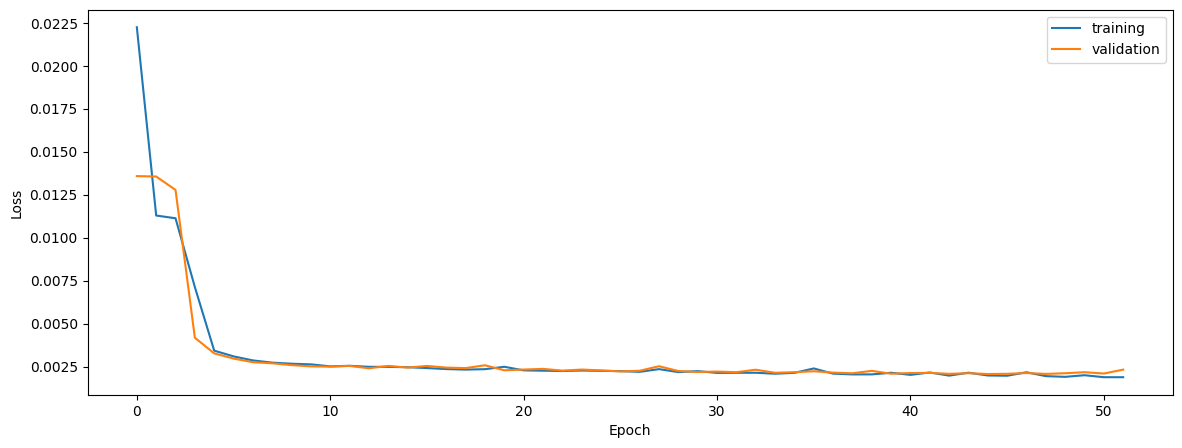

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9109682968341849
0.9209171734899815
0.8947127223124447


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.9109682968341849
0.9209171734899815
0.8947127223124447


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.8952150343494563
0.9059667134290722
0.8859099648625671


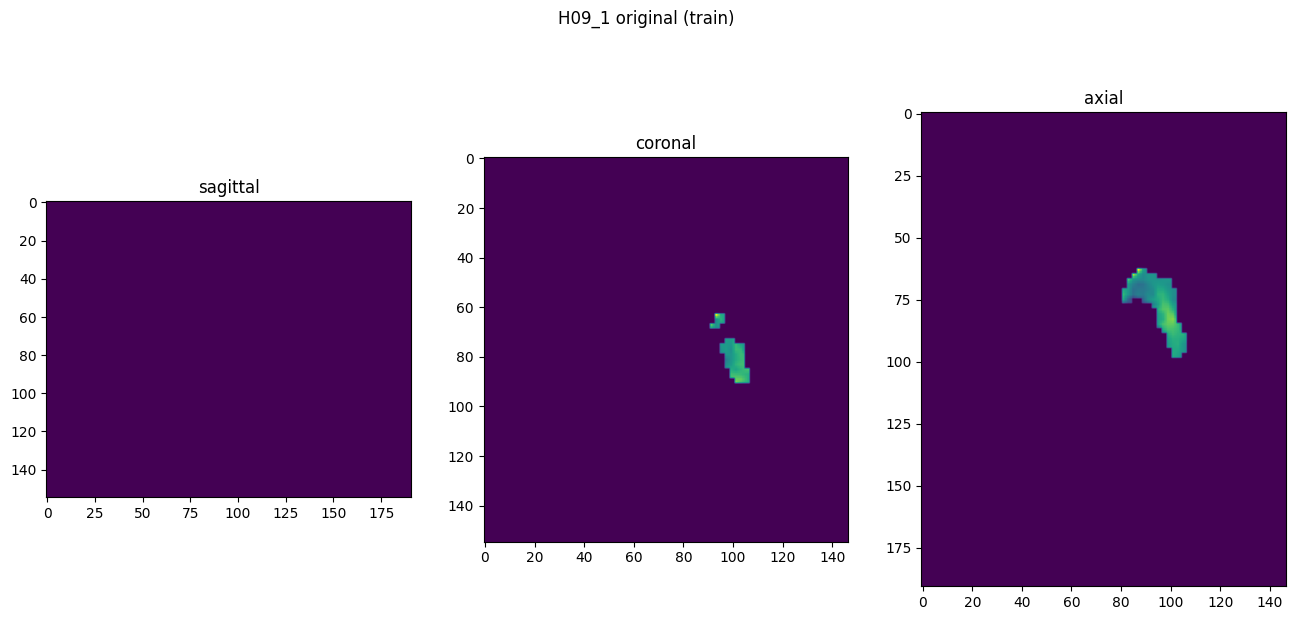

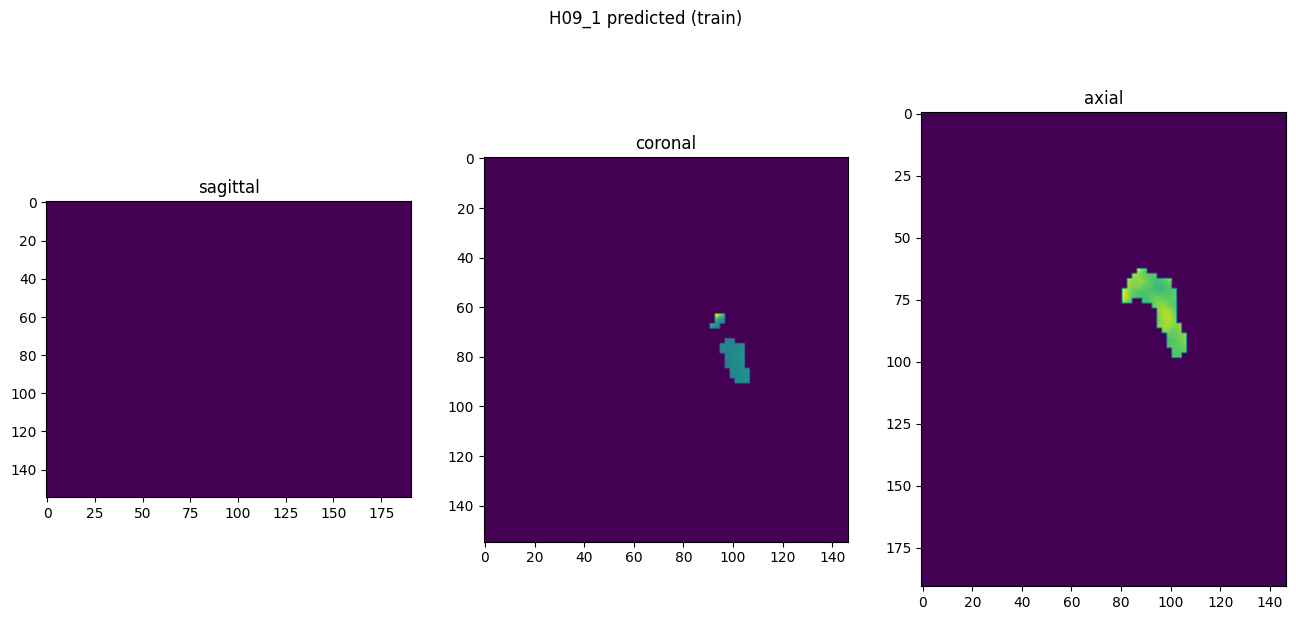

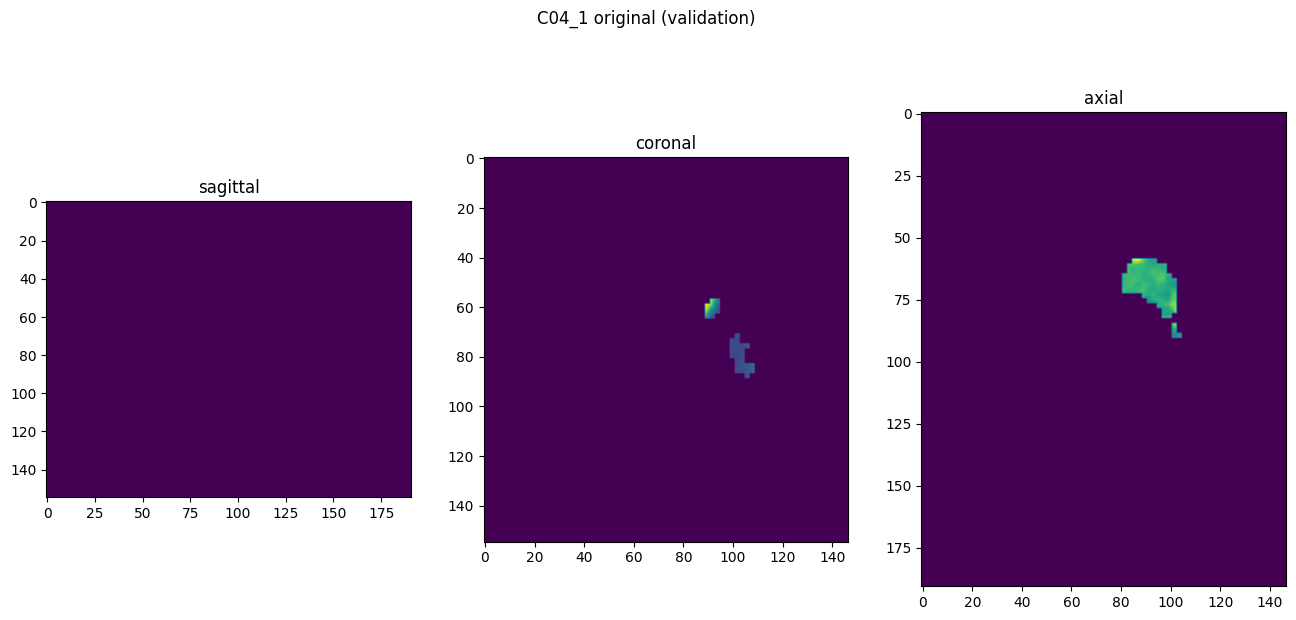

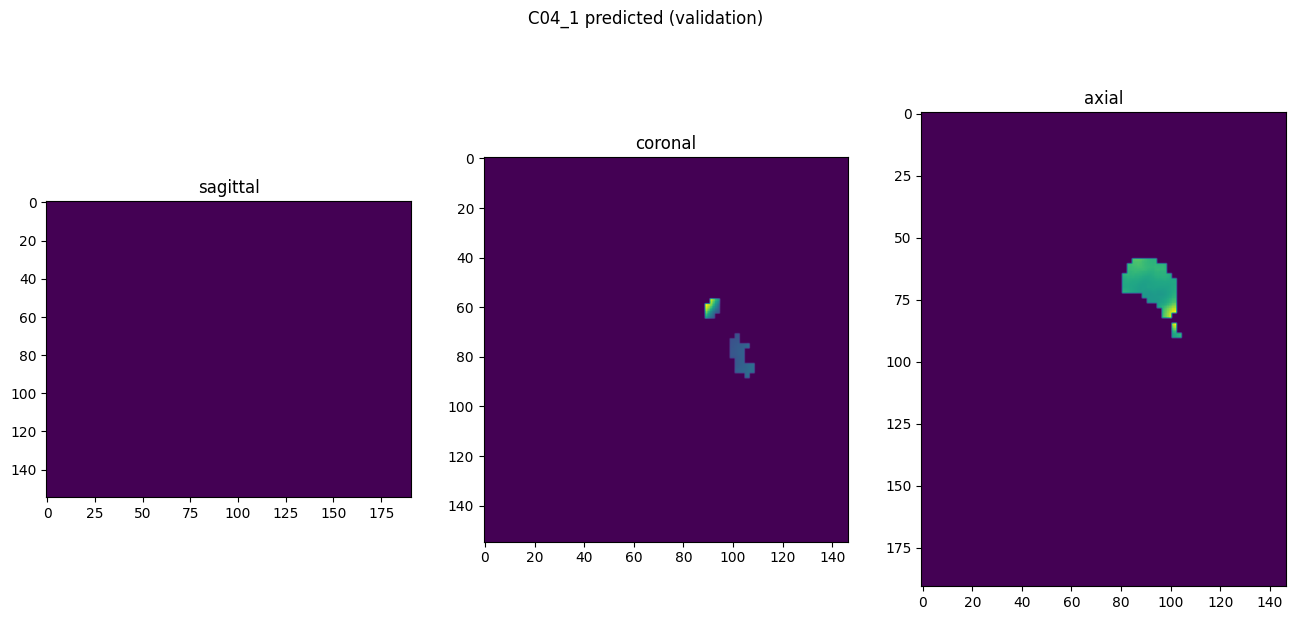

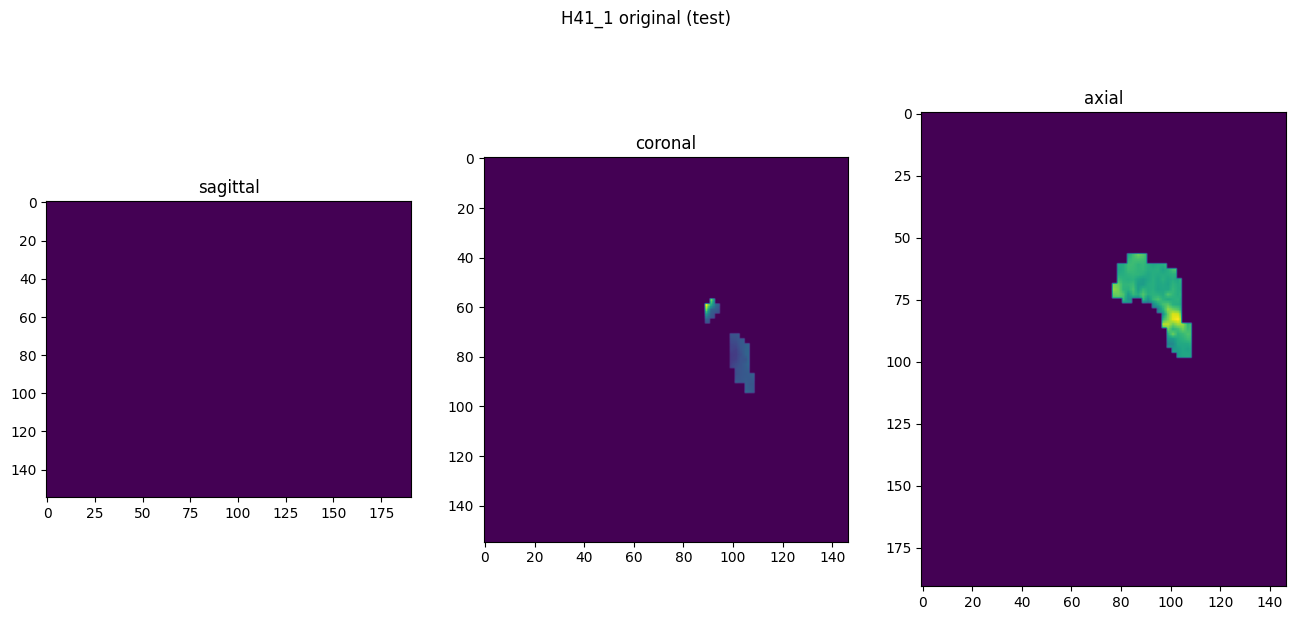

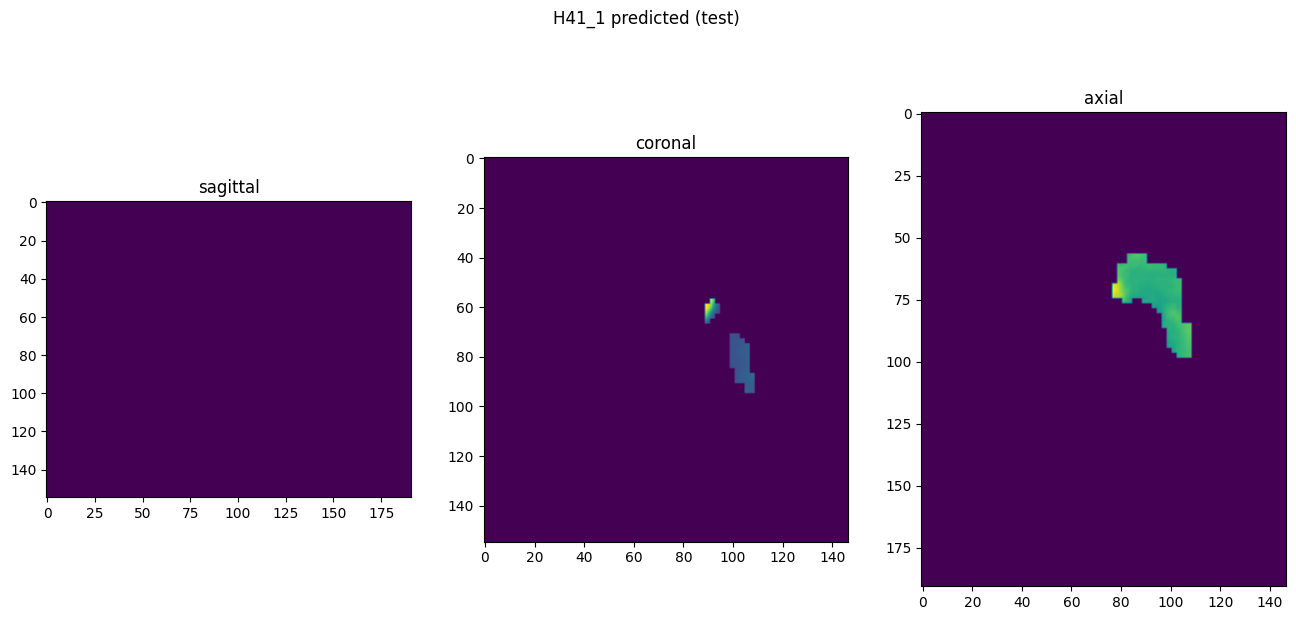

In [10]:
showResults(model, gen, threshold=None, background=False)